# 风电功率预测：使用CatBoost进行16点预测

本notebook使用CatBoost来预测风电功率未来16个时间点的值（对应4小时，每15分钟一个点）。
由于CatBoost每次只能预测一个目标值，我们将训练16个独立的模型，每个模型预测未来的一个特定时间点。

## 任务说明
- 输入: 过去96个时间点的风电功率数据（对应24小时，每15分钟一个点）
- 输出: 未来16个时间点的风电功率预测（对应4小时）
- 方法: 训练16个CatBoost模型，每个模型预测未来的一个特定时间点

In [1]:
# ===== 超参数配置 =====
# 集中管理所有超参数，方便调试和调优

class Config:
    # 数据相关
    seq_length = 96          # 输入序列长度（96个时间点，24小时，每点15分钟）
    pred_length = 16         # 预测序列长度（16个时间点，4小时）
    train_val_split = 0.8    # 训练验证集分割比例
    
    # 数据加载
    batch_size = 128         
    num_workers = 8          
    
    # 风电功率特征工程相关
    use_feature_engineering = False  # 是否使用特征工程，False时直接使用96个时间点
    use_raw_time_series = True       # 直接使用原始时间序列作为特征
    time_interval_minutes = 15      # 时间间隔（分钟）

    add_lag_features = False        # 添加滞后特征（风电功率有自相关性）
    lag_steps = [1, 2, 4, 8, 16, 24, 48, 96]  # 滞后步数（15min, 30min, 1h, 2h, 4h, 6h, 12h, 24h）

    add_ramp_features = False       # 添加功率爬坡特征（风电重要特性）
    ramp_windows = [4, 8, 16]      # 爬坡检测窗口


    
    # SHAP特征选择配置
    enable_shap_feature_selection = True  # 是否启用SHAP特征选择
    shap_selected_features = 8        # 为每个模型选择的特征数量
    shap_sample_size = 1000              # 用于SHAP分析的样本数量
    enable_two_stage_training = True     # 是否启用两阶段训练
    
    # CatBoost模型参数
    learning_rate = 0.05
    max_depth = 12
    n_estimators = 1000
    l2_leaf_reg = 3.0
    random_strength = 1.0
    bagging_temperature = 1.0
    od_type = 'Iter'
    od_wait = 50             # 早停轮数
    verbose = 100            # 训练过程打印间隔
    
    # 训练相关
    num_epochs = 1           # CatBoost不需要多个epoch
    early_stop_min_delta = 0.0001  # 早停最小改善幅度
    
    # 并行训练配置
    use_parallel_training = True  # 是否使用并行训练
    max_processes = 2      # 最大并行进程数s
    
    # 其他
    random_seed = 42         # 随机种子
    task_type = 'CPU'        # 'CPU' 或 'GPU'

    
    # 路径配置
    data_dir = '/data/jinming/ee_prediction/data'
    model_save_dir = '/data/jinming/ee_prediction/catboost/models'
    results_dir = '/data/jinming/ee_prediction/catboost/results'
    
# 创建配置实例
config = Config()

print("=== Hyperparameter Configuration ===")
print(f"Time Configuration: {config.seq_length} points ({config.seq_length * config.time_interval_minutes / 60:.1f}h) -> {config.pred_length} points ({config.pred_length * config.time_interval_minutes / 60:.1f}h)")
print(f"Feature Engineering: Enabled={config.use_feature_engineering}")
if not config.use_feature_engineering:
    print(f"Using raw time series: {config.seq_length} time points as features")
print(f"SHAP Feature Selection: Enabled={config.enable_shap_feature_selection}")
if config.enable_shap_feature_selection:
    print(f"  - Selected features per model: {config.shap_selected_features}")
    print(f"  - Two-stage training: {config.enable_two_stage_training}")
print(f"CatBoost Model: Max depth {config.max_depth}, Learning rate {config.learning_rate}, Estimators {config.n_estimators}")
print(f"Task type: {config.task_type}")
print(f"Parallel Training: {config.use_parallel_training} (Max processes: {config.max_processes})")
print("=" * 50)

=== Hyperparameter Configuration ===
Time Configuration: 96 points (24.0h) -> 16 points (4.0h)
Feature Engineering: Enabled=False
Using raw time series: 96 time points as features
SHAP Feature Selection: Enabled=True
  - Selected features per model: 8
  - Two-stage training: True
CatBoost Model: Max depth 12, Learning rate 0.05, Estimators 1000
Task type: CPU
Parallel Training: True (Max processes: 2)


In [2]:
# 导入所需库
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor, Pool
import json
import time
from tqdm import tqdm
import warnings
import multiprocessing as mp
from multiprocessing import Pool as ProcessPool
from functools import partial
import shap
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 设置可见的GPU设备
warnings.filterwarnings('ignore')

# 设置随机种子确保可重现性
np.random.seed(config.random_seed)

# 确保目录存在
os.makedirs(config.model_save_dir, exist_ok=True)
os.makedirs(config.results_dir, exist_ok=True)

# 特征选择配置 - 允许为每个模型指定输入特征
class FeatureSelector:
    """特征选择器 - 允许为每个预测时间点选择不同的输入特征"""
    
    def __init__(self, total_time_points=96):
        self.total_time_points = total_time_points
        self.feature_configs = {}
        self.auto_select_enabled = False
        self.shap_based_selection = False
    
    def set_features_for_horizon(self, horizon, feature_indices):
        """为指定的预测时间点设置输入特征
        
        Args:
            horizon: 预测时间点 (1-16)
            feature_indices: 特征索引列表，例如 [1,2,3,4] 表示使用 t-1, t-2, t-3, t-4
        """
        self.feature_configs[horizon] = feature_indices
    
    def enable_auto_selection(self, method='importance', top_k=32):
        """启用自动特征选择
        
        Args:
            method: 选择方法 ('importance', 'shap', 'correlation')
            top_k: 选择前k个最重要的特征
        """
        self.auto_select_enabled = True
        self.selection_method = method
        self.top_k = top_k
        if method == 'shap':
            self.shap_based_selection = True
    
    def get_features_for_horizon(self, horizon):
        """获取指定预测时间点的特征索引"""
        if horizon in self.feature_configs:
            return self.feature_configs[horizon]
        else:
            # 默认使用所有96个时间点
            return list(range(1, self.total_time_points + 1))
    
    def get_feature_names_for_horizon(self, horizon):
        """获取指定预测时间点的特征名称"""
        indices = self.get_features_for_horizon(horizon)
        return [f't-{i}' for i in indices]
    
    def auto_select_features(self, model, X_data, horizon, method='importance'):
        """基于模型自动选择特征"""
        if not self.auto_select_enabled:
            return list(range(1, self.total_time_points + 1))
        
        if method == 'shap' and SHAP_AVAILABLE:
            # 使用SHAP进行特征选择
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data[:min(500, len(X_data))])
            feature_importance = np.abs(shap_values).mean(0)
        else:
            # 使用CatBoost内置特征重要性
            feature_importance = model.get_feature_importance()
        
        # 选择前top_k个最重要的特征
        top_indices = np.argsort(feature_importance)[::-1][:self.top_k]
        selected_features = [i+1 for i in top_indices]  # 转换为t-x格式
        return sorted(selected_features)

# 创建特征选择器实例
feature_selector = FeatureSelector()

# 示例配置 - 可以为不同的预测时间点配置不同的特征集合
# 这里展示如何配置前几个模型使用不同的特征集合
# feature_selector.set_features_for_horizon(1, list(range(1, 17)))  # t+1 使用前16个时间点
# feature_selector.set_features_for_horizon(4, list(range(1, 33)))  # t+4 使用前32个时间点
# feature_selector.set_features_for_horizon(8, list(range(1, 49)))  # t+8 使用前48个时间点
# feature_selector.set_features_for_horizon(16, list(range(1, 97))) # t+16 使用所有96个时间点

# 启用自动特征选择（可选）
feature_selector.enable_auto_selection(method='shap', top_k=48)

print("Feature selection configuration ready.")
print("Use feature_selector.set_features_for_horizon(horizon, indices) to configure features for each model.")
print("Use feature_selector.enable_auto_selection() to enable automatic feature selection.")

print(f'Using task type: {config.task_type}')
print(f'Parallel training enabled: {config.use_parallel_training}')
if config.use_parallel_training:
    print(f'Maximum processes: {config.max_processes}')

Feature selection configuration ready.
Use feature_selector.set_features_for_horizon(horizon, indices) to configure features for each model.
Use feature_selector.enable_auto_selection() to enable automatic feature selection.
Using task type: CPU
Parallel training enabled: True
Maximum processes: 2


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# 加载数据
train_data = pd.read_excel(f'{config.data_dir}/train.xlsx')
test_data = pd.read_excel(f'{config.data_dir}/test.xlsx')

# 提取功率数据（第一列是实际功率）
train_power = train_data.iloc[:, 0].values
test_power = test_data.iloc[:, 0].values

print(f"Training data length: {len(train_power)}")
print(f"Testing data length: {len(test_power)}")
print(f"Training data range: [{train_power.min():.4f}, {train_power.max():.4f}]")
print(f"Testing data range: [{test_power.min():.4f}, {test_power.max():.4f}]")

# 检查原始数据中的负数情况
train_negative_count = np.sum(train_power < 0)
test_negative_count = np.sum(test_power < 0)
print(f"Original negative values in training data: {train_negative_count}")
print(f"Original negative values in testing data: {test_negative_count}")
if train_negative_count > 0 or test_negative_count > 0:
    print("Negative values will be converted to 0 during preprocessing")

# 数据预处理（简化版：数据已经归一化，只需处理负值）
def simplified_data_preprocessing(data, config):
    """简化的数据预处理：只处理负值转换为0"""
    processed_data = data.copy()
    
    # 将负数转换为0（这是唯一需要的预处理步骤）
    processed_data = np.where(processed_data < 0, 0, processed_data)
    
    print(f"Processed data range: [{processed_data.min():.4f}, {processed_data.max():.4f}]")
    negative_count = np.sum(data < 0)
    if negative_count > 0:
        print(f"Converted {negative_count} negative values to 0")
    else:
        print("No negative values found")
    
    return processed_data, None  # 返回None作为scaler（不需要）

# 应用简化预处理
if config.use_feature_engineering:
    print("\n=== Simplified Data Preprocessing ===")
    train_power_processed, train_scaler = simplified_data_preprocessing(train_power, config)
    test_power_processed, test_scaler = simplified_data_preprocessing(test_power, config)
    
    print(f"Final training data range: [{train_power_processed.min():.4f}, {train_power_processed.max():.4f}]")
    print(f"Final testing data range: [{test_power_processed.min():.4f}, {test_power_processed.max():.4f}]")
else:
    # 即使不使用特征工程，也需要简单的负值处理
    train_power_processed = np.where(train_power < 0, 0, train_power)
    test_power_processed = np.where(test_power < 0, 0, test_power)
    train_scaler = None
    test_scaler = None
    print("Applied basic negative value conversion only")

Training data length: 6999
Testing data length: 2999
Training data range: [-0.0094, 1.0000]
Testing data range: [-0.0093, 0.9446]
Original negative values in training data: 445
Original negative values in testing data: 138
Negative values will be converted to 0 during preprocessing
Applied basic negative value conversion only


In [4]:
def create_features(data, seq_length, config):
    """
    为每个时间窗口创建特征
    
    参数:
    data: 原始时间序列数据
    seq_length: 输入序列长度
    config: 配置对象
    
    返回:
    features: 特征矩阵 [样本数, 特征数]
    feature_names: 特征名称列表
    """
    
    features_list = []
    feature_names = []
    
    # 1. 原始时间序列特征（如果启用）
    if config.use_raw_time_series:
        # 添加96个时间点的功率值作为特征
        features_list.extend(list(data))
        feature_names.extend([f't-{seq_length-i}' for i in range(seq_length)])
    
    # 2. 统计特征（如果启用特征工程）
    if config.use_feature_engineering:
        power_series = pd.Series(data)
        
        # 基本特征 - 最后一个时间点的功率值（当前值）
        features_list.append(data[-1])
        feature_names.append('current_power')
        
        # 统计特征 - 输入序列的统计量
        features_list.append(np.mean(data))
        feature_names.append('mean_power')
        
        features_list.append(np.std(data))
        feature_names.append('std_power')
        
        features_list.append(np.min(data))
        feature_names.append('min_power')
        
        features_list.append(np.max(data))
        feature_names.append('max_power')
        
        # 滞后特征
        if config.add_lag_features:
            for lag in config.lag_steps:
                if lag < len(data):
                    features_list.append(data[-lag])
                    feature_names.append(f'lag_{lag}')
        
        # 功率爬坡特征
        if config.add_ramp_features:
            for window in config.ramp_windows:
                # 功率爬坡率：单位时间内功率变化幅度
                if window < len(data):
                    ramp_rate = data[-1] - data[-(window+1)]
                    features_list.append(ramp_rate)
                    feature_names.append(f'ramp_rate_{window}')
                    
                    # 绝对爬坡率
                    abs_ramp_rate = np.abs(ramp_rate)
                    features_list.append(abs_ramp_rate)
                    feature_names.append(f'abs_ramp_rate_{window}')
                    
                    # 爬坡方向（上升=1，下降=-1，稳定=0）
                    ramp_direction = np.sign(ramp_rate)
                    features_list.append(ramp_direction)
                    feature_names.append(f'ramp_direction_{window}')
        
    
    # 如果两者都没有启用，返回默认的96个时间点
    if not config.use_feature_engineering and not config.use_raw_time_series:
        features_list = list(data)
        feature_names = [f't-{seq_length-i}' for i in range(seq_length)]
    
    return np.array(features_list), feature_names

# 准备CatBoost数据
# filepath: [catboost_16_point_prediction.ipynb](http://_vscodecontentref_/0)
def prepare_catboost_data(data, seq_length, pred_length, config, is_test=False):
    """
    准备CatBoost数据
    
    参数:
    data: 原始时间序列数据
    seq_length: 输入序列长度
    pred_length: 预测序列长度
    config: 配置对象
    is_test: 是否为测试集
    
    返回:
    X: 特征矩阵 [样本数, 特征数]
    y: 目标矩阵 [样本数, pred_length]（如果is_test=True则为None）
    feature_names: 特征名称列表
    """
    X_list = []
    y_list = []
    
    # 对于训练和测试数据，都需要确保有足够的数据点来构造完整的预测目标
    if is_test:
        # 测试数据也需要确保有完整的预测目标用于评估
        max_idx = len(data) - pred_length + 1
    else:
        # 训练数据
        max_idx = len(data) - pred_length + 1
    
    # 对每个样本进行特征工程
    for i in range(seq_length, max_idx):
        # 获取当前样本的输入序列
        input_seq = data[i - seq_length:i]
        
        # 对输入序列进行特征工程
        features, feature_names = create_features(input_seq, seq_length, config)
        X_list.append(features)
        
        # 添加目标值（训练和测试都需要，用于评估）
        if i + pred_length <= len(data):
            y_list.append(data[i:i + pred_length])
        else:
            # 如果数据不足pred_length，则填充NaN或跳过
            break
    
    X = np.array(X_list)
    y = np.array(y_list) if y_list else None
    
    return X, y, feature_names

# 生成训练和测试数据
print("Preparing training data...")
X_train, y_train, feature_names = prepare_catboost_data(train_power_processed, config.seq_length, config.pred_length, config)

print("Preparing test data...")
X_test, y_test, _ = prepare_catboost_data(test_power_processed, config.seq_length, config.pred_length, config)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape if y_test is not None else 'None'}")
print(f"Number of features: {len(feature_names)}")
print(f"Feature names: {feature_names}")

# 按训练集和验证集分割数据（时间顺序）
train_size = int(len(X_train) * config.train_val_split)
X_train_split = X_train[:train_size]
y_train_split = y_train[:train_size]
X_val = X_train[train_size:]
y_val = y_train[train_size:]

print(f"Training set size: {len(X_train_split)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Preparing training data...
Preparing test data...
X_train shape: (6888, 96)
y_train shape: (6888, 16)
X_test shape: (2888, 96)
y_test shape: (2888, 16)
Number of features: 96
Feature names: ['t-96', 't-95', 't-94', 't-93', 't-92', 't-91', 't-90', 't-89', 't-88', 't-87', 't-86', 't-85', 't-84', 't-83', 't-82', 't-81', 't-80', 't-79', 't-78', 't-77', 't-76', 't-75', 't-74', 't-73', 't-72', 't-71', 't-70', 't-69', 't-68', 't-67', 't-66', 't-65', 't-64', 't-63', 't-62', 't-61', 't-60', 't-59', 't-58', 't-57', 't-56', 't-55', 't-54', 't-53', 't-52', 't-51', 't-50', 't-49', 't-48', 't-47', 't-46', 't-45', 't-44', 't-43', 't-42', 't-41', 't-40', 't-39', 't-38', 't-37', 't-36', 't-35', 't-34', 't-33', 't-32', 't-31', 't-30', 't-29', 't-28', 't-27', 't-26', 't-25', 't-24', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']
Training set size: 5510
Validation set size: 1378


In [5]:
# 训练16个CatBoost模型，每个模型预测一个未来时间点
models = []
training_metrics = []

# 评估指标计算函数
def calculate_CR(PM, PP):
    """
    计算CR指标（准确度指标）
    
    参数:
    PM: 实际值数组
    PP: 预测值数组
    
    返回:
    CR: CR指标值（百分比）
    """
    N = len(PM)
    Ri = np.zeros(N)
    for i in range(N):
        if PM[i] > 0.2:
            Ri[i] = (PM[i] - PP[i]) / PM[i]
        else:
            Ri[i] = (PM[i] - PP[i]) / 0.2
    rms_error = np.sqrt(np.mean(Ri**2))
    CR = (1 - rms_error) * 100
    return CR

def calculate_metrics(y_true, y_pred):
    """计算各种评估指标"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # 使用正确的CR计算方法
    cr = calculate_CR(y_true, y_pred)
    
    return {
        'rmse': rmse,
        'mae': mae,
        'cr': cr
    }

# 并行训练函数
def train_single_model(model_idx, X_train_split, y_train_split, X_val, y_val, config):
    """
    训练单个CatBoost模型的函数，用于并行处理
    
    参数:
    model_idx: 模型索引（0-15）
    X_train_split: 训练特征
    y_train_split: 训练目标
    X_val: 验证特征
    y_val: 验证目标
    config: 配置对象
    
    返回:
    model: 训练好的模型
    metrics: 训练指标
    model_idx: 模型索引
    """
    # 为当前时间点创建CatBoost模型
    model = CatBoostRegressor(
        iterations=config.n_estimators,
        learning_rate=config.learning_rate,
        depth=config.max_depth,
        l2_leaf_reg=config.l2_leaf_reg,
        random_strength=config.random_strength,
        bagging_temperature=config.bagging_temperature,
        od_type=config.od_type,
        od_wait=config.od_wait,
        verbose=False,  # 关闭详细输出以避免并行时的混乱
        random_seed=config.random_seed + model_idx,  # 为每个模型设置不同的随机种子
        task_type=config.task_type
    )
    
    # 训练模型
    model.fit(
        X_train_split, y_train_split[:, model_idx],
        eval_set=[(X_val, y_val[:, model_idx])],
        use_best_model=True,
        early_stopping_rounds=config.od_wait,
        verbose=False  # 关闭详细输出
    )
    
    # 在验证集上评估
    val_pred = model.predict(X_val)
    val_metrics = calculate_metrics(y_val[:, model_idx], val_pred)
    
    # 保存模型
    model_path = f"{config.model_save_dir}/catboost_point_{model_idx+1}.cbm"
    model.save_model(model_path)
    
    # 返回结果
    metrics = {
        'horizon': model_idx+1,
        'best_iteration': model.best_iteration_,
        'train_rmse': model.get_best_score()['learn']['RMSE'],
        'val_rmse': model.get_best_score()['validation']['RMSE'],
        'val_custom_metrics': val_metrics
    }
    
    return model, metrics, model_idx

print("Training 16 CatBoost models...")

if config.use_parallel_training:
    print(f"Using parallel training with {config.max_processes} processes")
    
    # 创建进程池
    with ProcessPool(processes=config.max_processes) as pool:
        # 准备并行训练任务
        train_tasks = []
        for i in range(config.pred_length):
            # 使用 partial 函数来固定参数
            task = partial(
                train_single_model,
                i, X_train_split, y_train_split, X_val, y_val, config
            )
            train_tasks.append(task)
        
        # 执行并行训练
        print("Starting parallel training...")
        results = []
        for i, task in enumerate(train_tasks):
            print(f"Submitting model {i+1} for training...")
            result = pool.apply_async(task)
            results.append(result)
        
        # 收集结果
        trained_models = [None] * config.pred_length
        all_metrics = [None] * config.pred_length
        
        print("Waiting for training completion...")
        for i, result in enumerate(results):
            try:
                model, metrics, model_idx = result.get(timeout=3600)  # 1小时超时
                trained_models[model_idx] = model
                all_metrics[model_idx] = metrics
                print(f"Model {model_idx+1} completed: Val RMSE = {metrics['val_custom_metrics']['rmse']:.6f}, Val CR = {metrics['val_custom_metrics']['cr']:.2f}%")
            except Exception as e:
                print(f"Error training model {i+1}: {e}")
                raise
        
        # 将结果赋值给全局变量
        models = trained_models
        training_metrics = all_metrics
        
else:
    # 顺序训练（作为备选方案）
    print("Using sequential training")
    for i in tqdm(range(config.pred_length), desc="Training models"):
        model, metrics, _ = train_single_model(i, X_train_split, y_train_split, X_val, y_val, config)
        models.append(model)
        training_metrics.append(metrics)
        print(f"Model {i+1}: Val RMSE = {metrics['val_custom_metrics']['rmse']:.6f}, Val CR = {metrics['val_custom_metrics']['cr']:.2f}%")

# 保存训练指标
with open(f"{config.results_dir}/training_metrics.json", "w") as f:
    json.dump(training_metrics, f, indent=2)

print("All models trained and saved successfully.")
print(f"Training completed using {'parallel' if config.use_parallel_training else 'sequential'} processing.")

Training 16 CatBoost models...
Using parallel training with 2 processes
Starting parallel training...
Submitting model 1 for training...
Submitting model 2 for training...
Submitting model 3 for training...
Submitting model 4 for training...
Submitting model 5 for training...
Submitting model 6 for training...
Submitting model 7 for training...
Submitting model 8 for training...
Submitting model 9 for training...
Submitting model 10 for training...
Submitting model 11 for training...
Submitting model 12 for training...
Submitting model 13 for training...
Submitting model 14 for training...
Submitting model 15 for training...
Submitting model 16 for training...
Waiting for training completion...
Model 1 completed: Val RMSE = 0.044046, Val CR = 83.72%
Model 2 completed: Val RMSE = 0.065442, Val CR = 76.07%
Model 3 completed: Val RMSE = 0.075520, Val CR = 72.51%
Model 4 completed: Val RMSE = 0.084372, Val CR = 68.64%
Model 5 completed: Val RMSE = 0.090517, Val CR = 66.01%
Model 6 complete

In [6]:
# 在测试集上评估模型
print("Evaluating models on test set...")

# 准备收集测试结果
test_predictions = np.zeros((len(X_test), config.pred_length))
test_metrics_overall = {}
test_metrics_by_point = []

# 使用每个模型进行预测
for i in range(config.pred_length):
    model = models[i]
    test_predictions[:, i] = model.predict(X_test)

# 计算整体性能指标
rmse_overall = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
mae_overall = mean_absolute_error(y_test.flatten(), test_predictions.flatten())

# 使用统一的CR计算方法
cr_overall = calculate_CR(y_test.flatten(), test_predictions.flatten())

test_metrics_overall = {
    'rmse': float(rmse_overall),
    'mae': float(mae_overall),
    'cr': float(cr_overall)
}

# 计算每个预测点的性能指标
step_rmse = []
step_mae = []
step_cr = []

for i in range(config.pred_length):
    point_metrics = calculate_metrics(y_test[:, i], test_predictions[:, i])
    test_metrics_by_point.append({
        'horizon': i+1,
        'rmse': float(point_metrics['rmse']),
        'mae': float(point_metrics['mae']),
        'cr': float(point_metrics['cr'])
    })
    
    step_rmse.append(point_metrics['rmse'])
    step_mae.append(point_metrics['mae'])
    step_cr.append(point_metrics['cr'])

# 保存测试指标
test_results = {
    'overall': test_metrics_overall,
    'by_point': test_metrics_by_point
}

with open(f"{config.results_dir}/test_metrics.json", "w") as f:
    json.dump(test_results, f, indent=2)

# 保存测试预测结果
test_df = pd.DataFrame(test_predictions, columns=[f'point_{i+1}' for i in range(config.pred_length)])
test_df.to_csv(f"{config.results_dir}/test_predictions.csv", index=False)

print(f"Test evaluation complete.")
print(f"Overall Test RMSE: {rmse_overall:.6f}")
print(f"Overall Test MAE: {mae_overall:.6f}")
print(f"Overall Test CR: {cr_overall:.2f}%")

Evaluating models on test set...
Test evaluation complete.
Overall Test RMSE: 0.136874
Overall Test MAE: 0.098824
Overall Test CR: 55.94%


开始特征重要性分析...
特征数量: 96
特征名称: ['t-96', 't-95', 't-94', 't-93', 't-92', 't-91', 't-90', 't-89', 't-88', 't-87']...

=== 传统特征重要性分析（CatBoost内置） ===


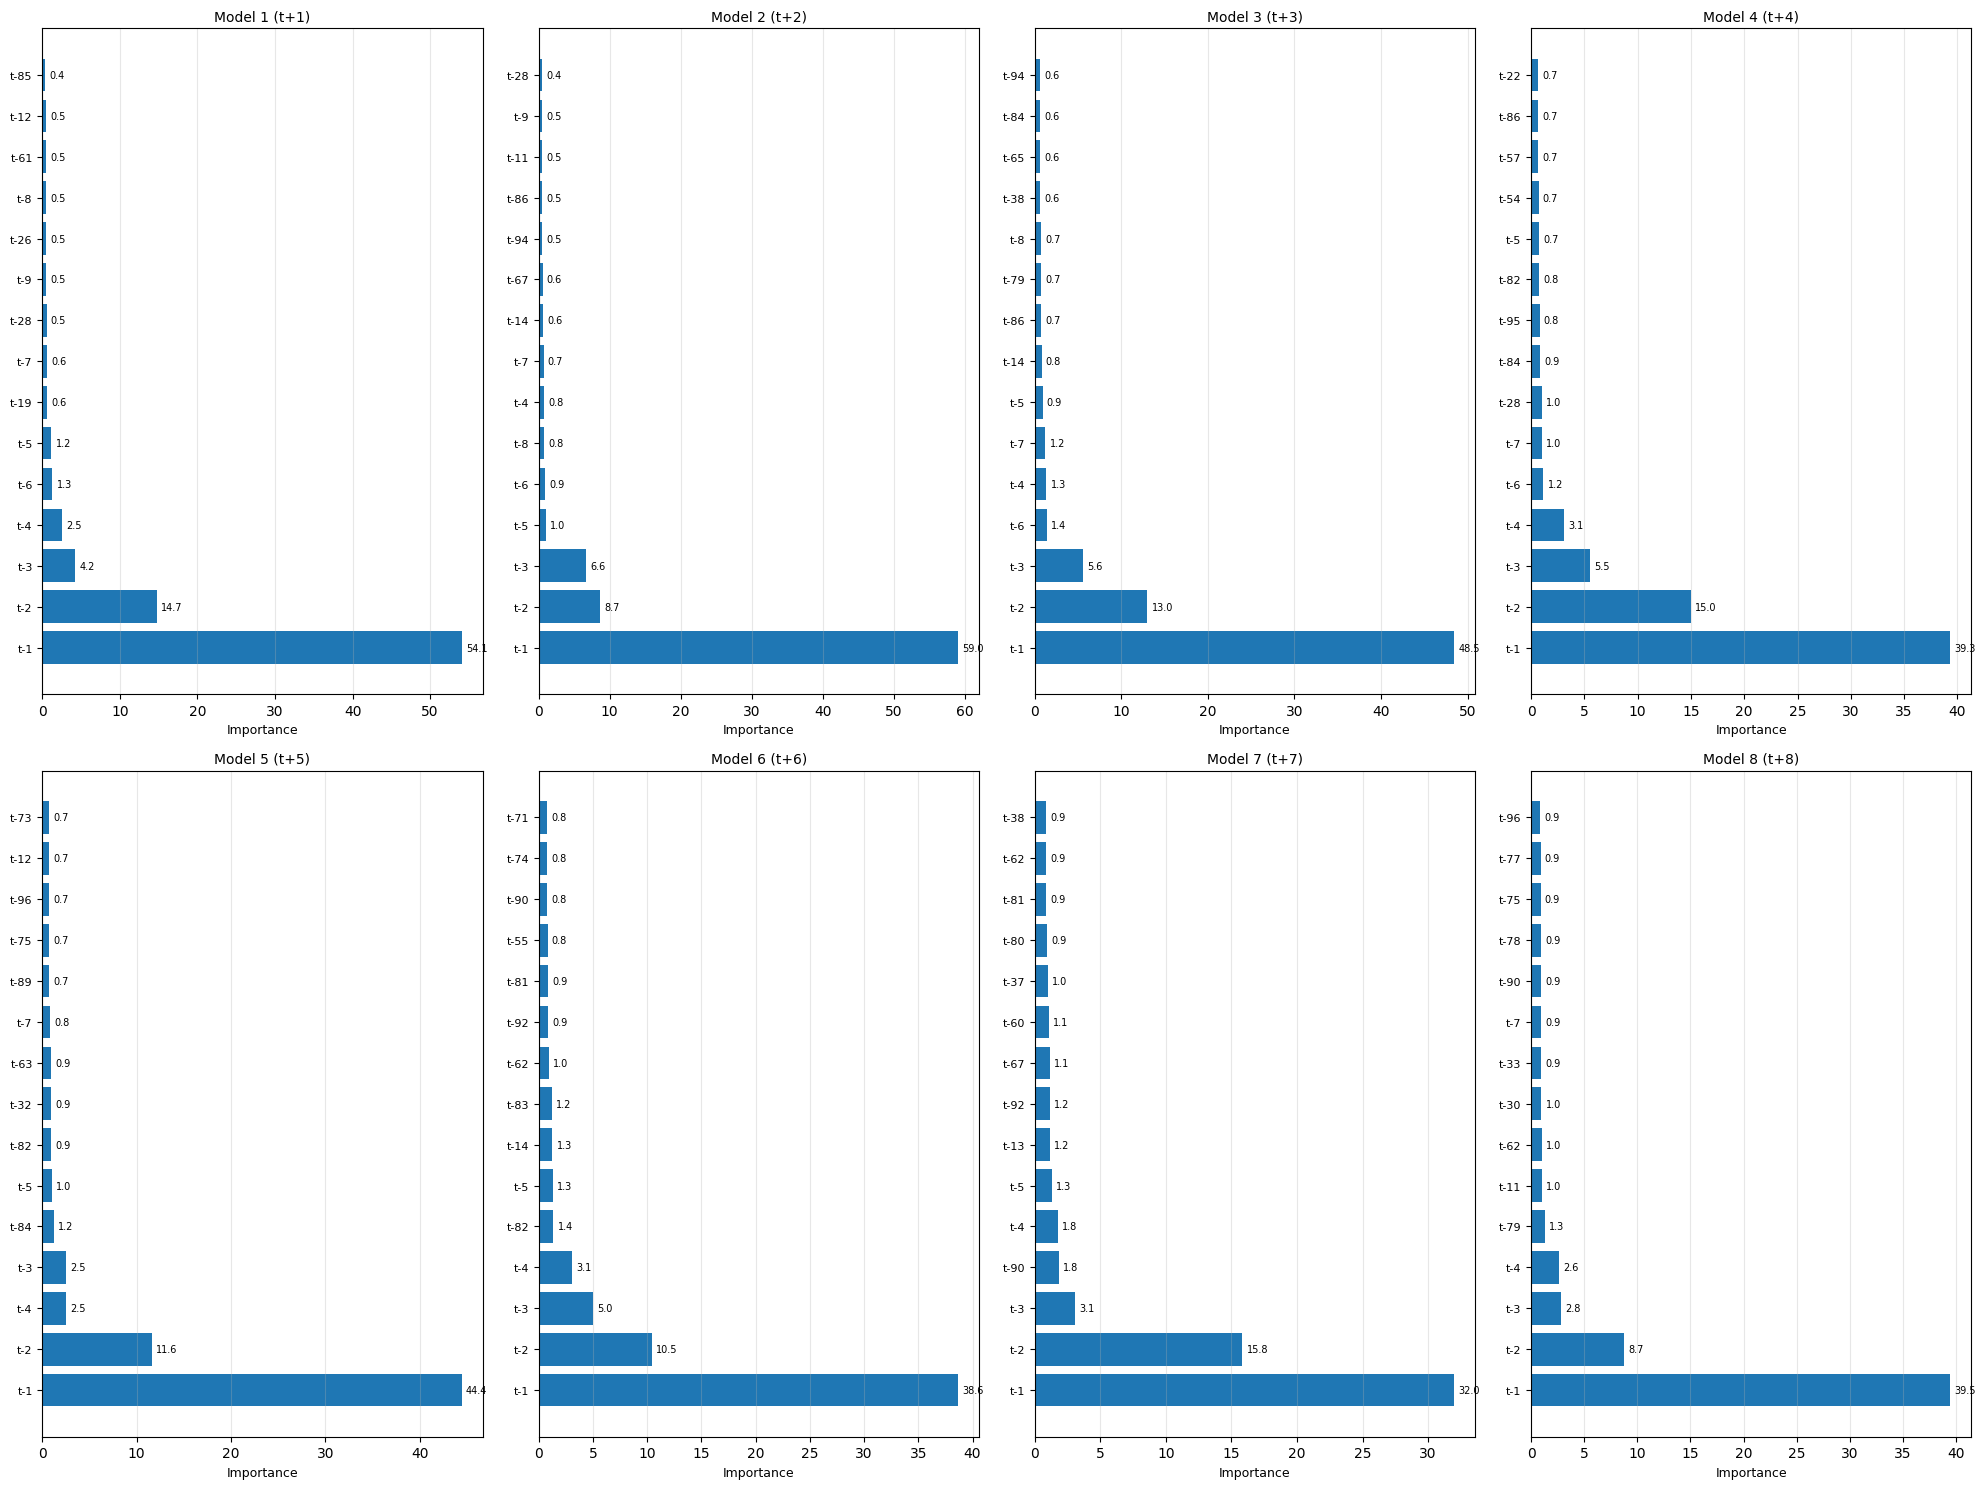


=== 所有模型平均特征重要性 ===


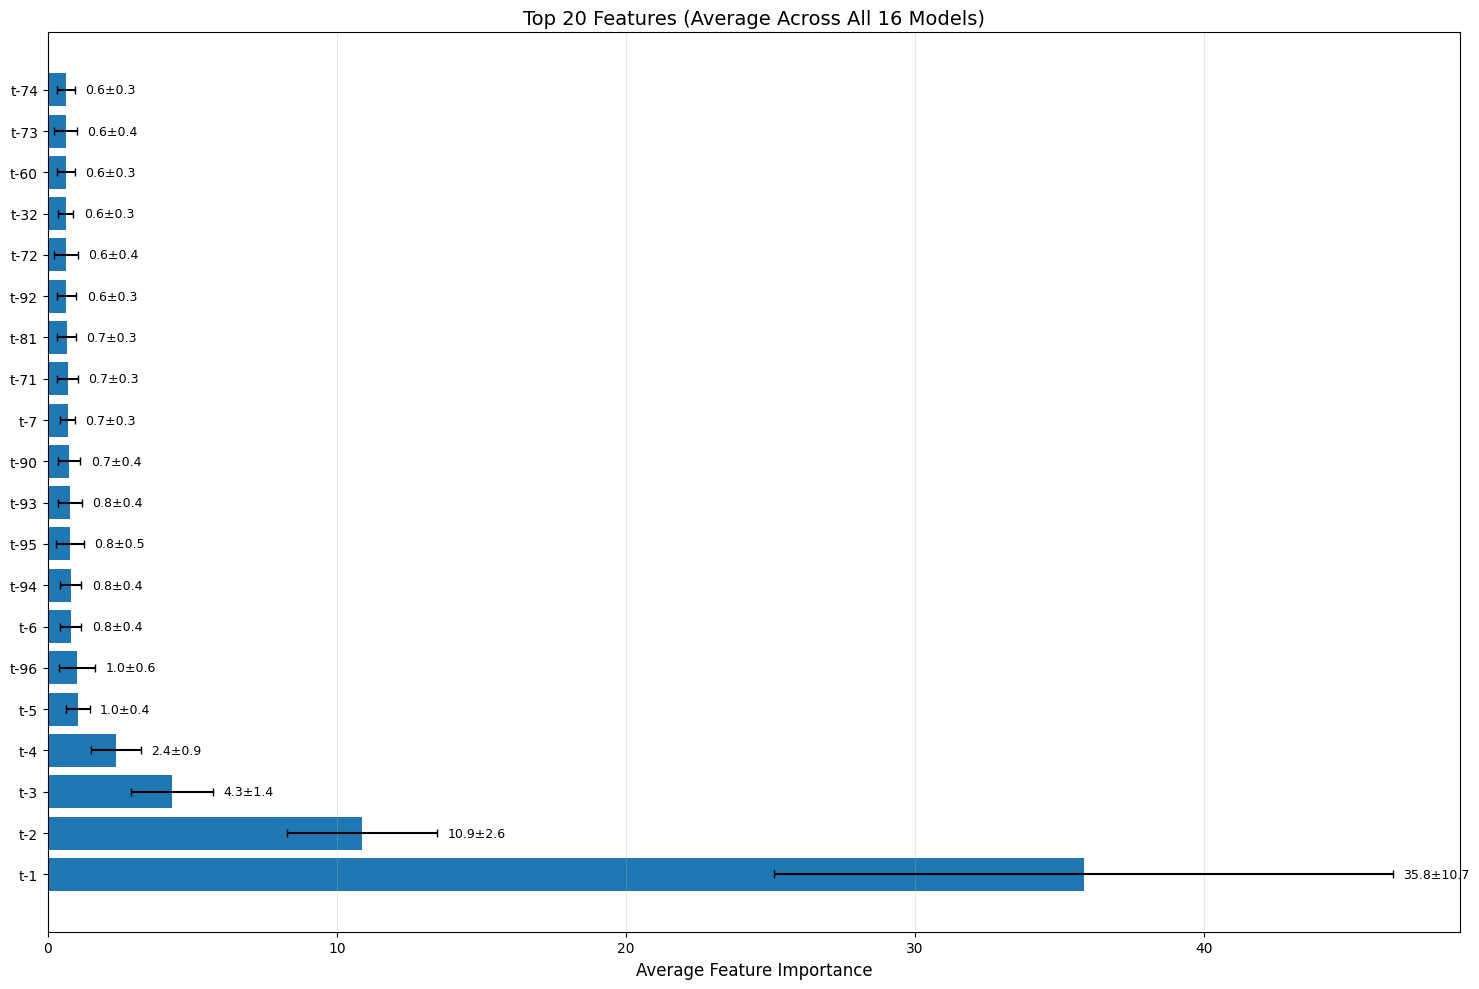


=== SHAP特征重要性分析 ===
使用1378个样本进行SHAP分析...
计算模型1的SHAP值...
计算模型2的SHAP值...
计算模型3的SHAP值...
计算模型4的SHAP值...
计算模型5的SHAP值...
计算模型6的SHAP值...
计算模型7的SHAP值...
计算模型8的SHAP值...
计算模型9的SHAP值...
计算模型10的SHAP值...
计算模型11的SHAP值...
计算模型12的SHAP值...
计算模型13的SHAP值...
计算模型14的SHAP值...
计算模型15的SHAP值...
计算模型16的SHAP值...
SHAP值计算完成！

=== SHAP Summary Plots ===


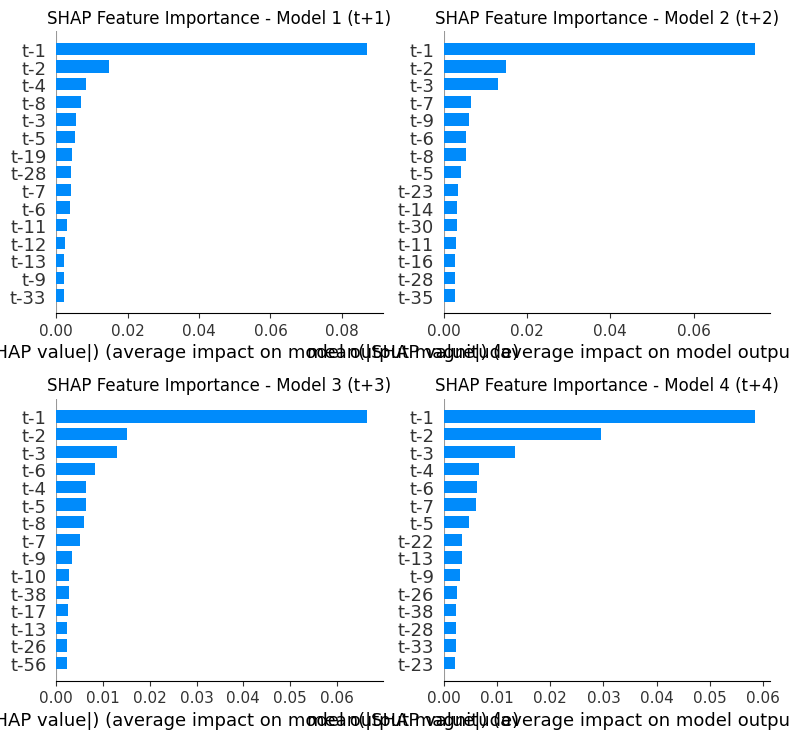


=== 所有模型SHAP重要性汇总 ===


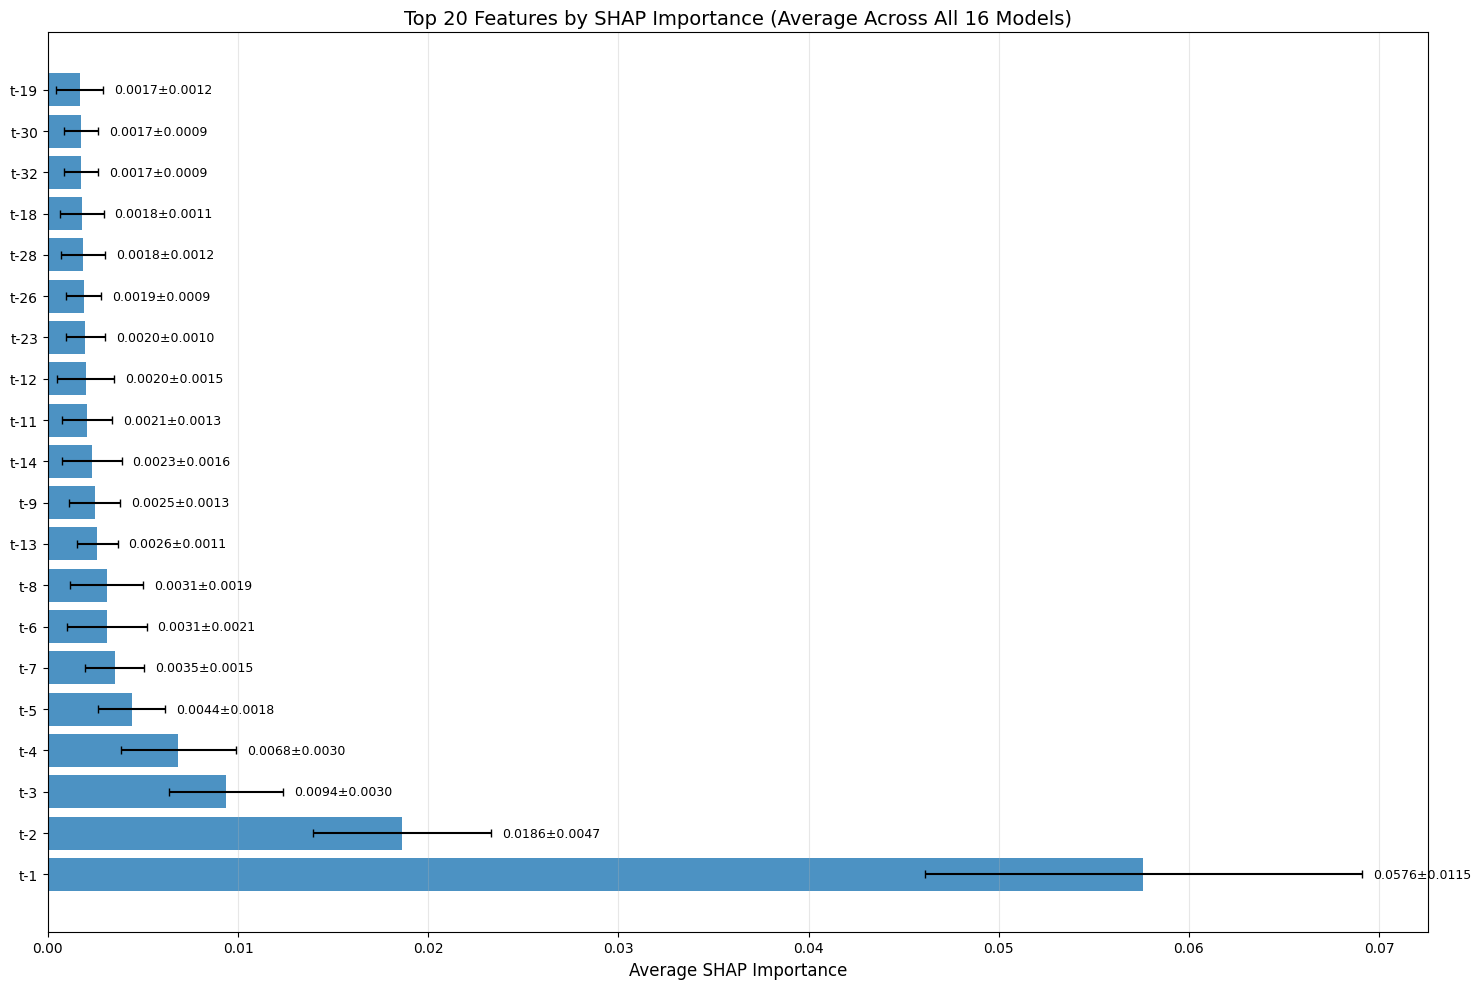


=== 特征重要性对比分析 ===


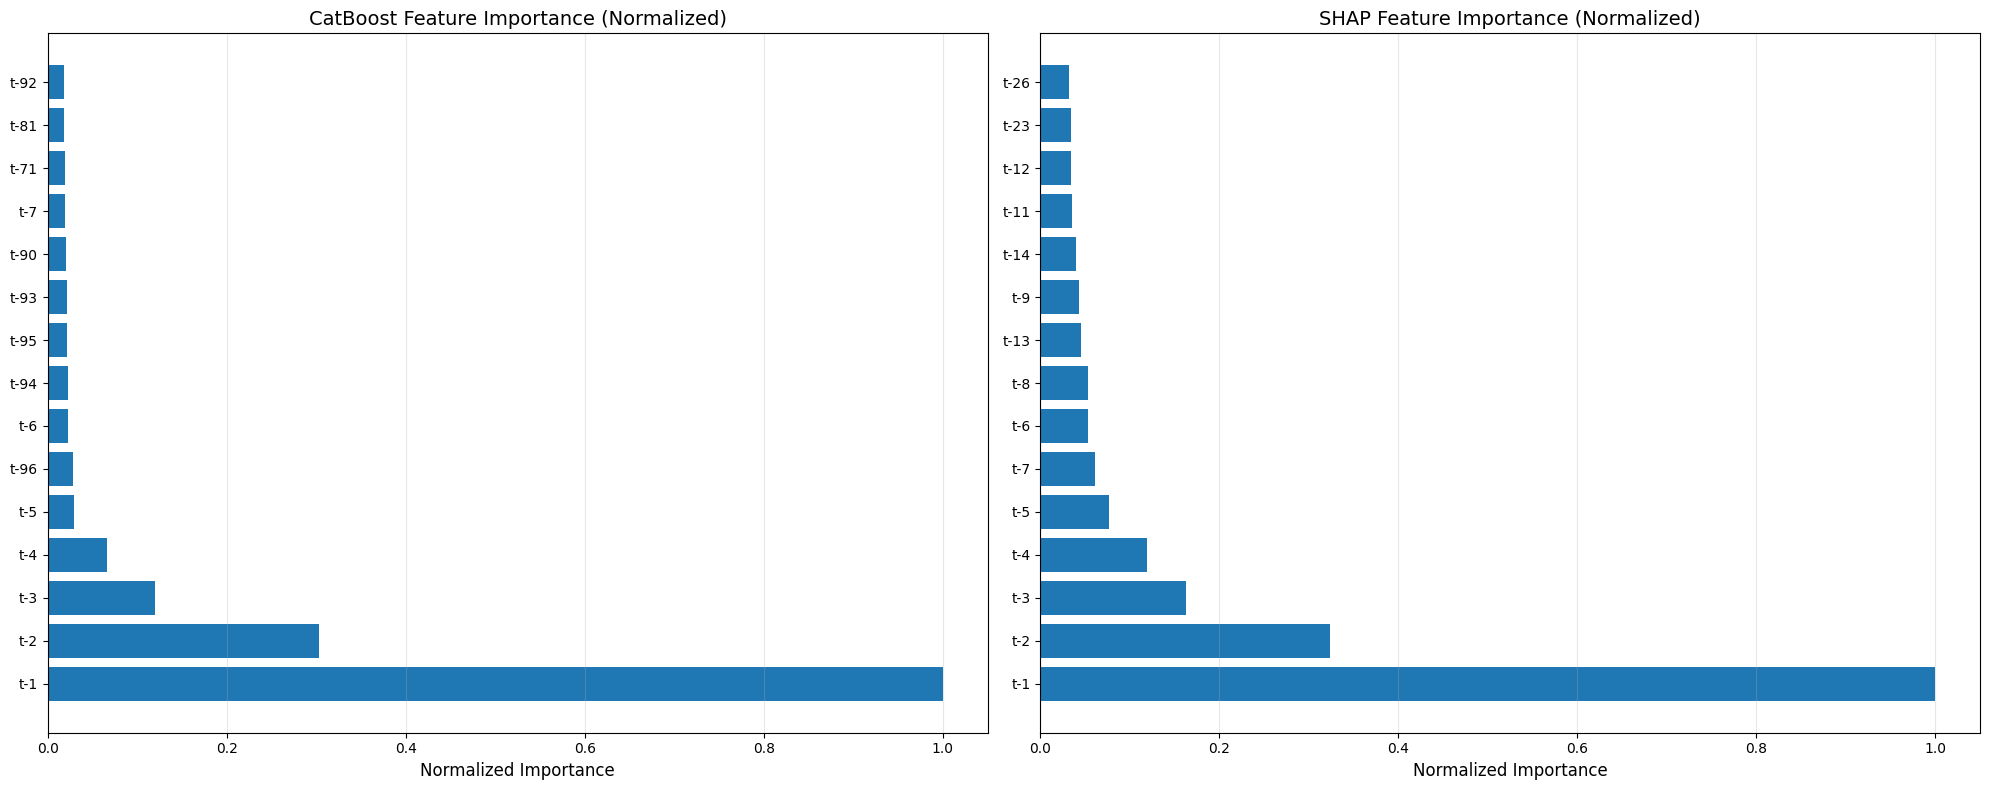


=== 保存特征重要性分析结果 ===
特征重要性分析完成！
结果已保存到 /data/jinming/ee_prediction/catboost/results/
- catboost_feature_importance.json: CatBoost特征重要性详细结果
- shap_feature_importance.json: SHAP特征重要性详细结果
- feature_importance_comparison.csv: 两种方法的对比结果
- 相关图表已保存为PNG文件


In [7]:
# 特征重要性分析 - 使用SHAP进行深入分析
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

print("开始特征重要性分析...")
print(f"特征数量: {len(feature_names)}")
print(f"特征名称: {feature_names[:10]}..." if len(feature_names) > 10 else f"特征名称: {feature_names}")

# 1. 传统特征重要性分析
print("\n=== 传统特征重要性分析（CatBoost内置） ===")
plt.figure(figsize=(20, 15))

# 显示前8个模型的特征重要性
for i in range(min(8, config.pred_length)):
    plt.subplot(2, 4, i+1)
    
    # 获取特征重要性
    feature_importances = models[i].get_feature_importance()
    
    # 创建特征重要性数据框
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
    
    # 绘制条形图
    plt.barh(range(len(importance_df)), importance_df['Importance'])
    plt.yticks(range(len(importance_df)), importance_df['Feature'], fontsize=8)
    plt.title(f'Model {i+1} (t+{i+1})', fontsize=10)
    plt.xlabel('Importance', fontsize=9)
    plt.grid(axis='x', alpha=0.3)
    
    # 添加数值标签
    for j, v in enumerate(importance_df['Importance']):
        plt.text(v + max(importance_df['Importance']) * 0.01, j, f'{v:.1f}', 
                va='center', fontsize=7)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/catboost_feature_importance_detailed.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. 所有模型的平均特征重要性
print("\n=== 所有模型平均特征重要性 ===")
plt.figure(figsize=(15, 10))

# 收集所有模型的特征重要性
all_importances = {}
for i, model in enumerate(models):
    importances = model.get_feature_importance()
    for j, feature in enumerate(feature_names):
        if feature not in all_importances:
            all_importances[feature] = []
        all_importances[feature].append(importances[j])

# 计算平均重要性和标准差
avg_importances = {feature: np.mean(values) for feature, values in all_importances.items()}
std_importances = {feature: np.std(values) for feature, values in all_importances.items()}

# 创建数据框
avg_importance_df = pd.DataFrame({
    'Feature': list(avg_importances.keys()),
    'Avg_Importance': list(avg_importances.values()),
    'Std_Importance': list(std_importances.values())
})
avg_importance_df = avg_importance_df.sort_values('Avg_Importance', ascending=False).head(20)

# 绘制带误差条的条形图
plt.barh(range(len(avg_importance_df)), avg_importance_df['Avg_Importance'], 
         xerr=avg_importance_df['Std_Importance'], capsize=3)
plt.yticks(range(len(avg_importance_df)), avg_importance_df['Feature'])
plt.title('Top 20 Features (Average Across All 16 Models)', fontsize=14)
plt.xlabel('Average Feature Importance', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 添加数值标签
for i, (avg, std) in enumerate(zip(avg_importance_df['Avg_Importance'], avg_importance_df['Std_Importance'])):
    plt.text(avg + std + max(avg_importance_df['Avg_Importance']) * 0.01, i, 
             f'{avg:.1f}±{std:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/average_feature_importance_with_std.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. SHAP特征重要性分析
print("\n=== SHAP特征重要性分析 ===")

# 为每个模型计算SHAP值
shap_values_all_models = []
shap_explanations = []

# 选择样本进行SHAP分析（使用验证集的一部分）
shap_sample_size = min(5000, len(X_val))
X_shap = X_val[:shap_sample_size]

print(f"使用{shap_sample_size}个样本进行SHAP分析...")

for i in range(config.pred_length):
    print(f"计算模型{i+1}的SHAP值...")
    model = models[i]
    
    # 创建SHAP解释器
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)
    
    # 保存SHAP值
    shap_values_all_models.append(shap_values)
    
    # 创建SHAP解释对象
    shap_explanation = shap.Explanation(values=shap_values, 
                                       base_values=explainer.expected_value,
                                       data=X_shap,
                                       feature_names=feature_names)
    shap_explanations.append(shap_explanation)
    
print("SHAP值计算完成！")

# 4. SHAP Summary Plot for first few models
print("\n=== SHAP Summary Plots ===")
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i in range(min(4, config.pred_length)):
    plt.sca(axes[i])
    shap.summary_plot(shap_values_all_models[i], X_shap, 
                     feature_names=feature_names, 
                     plot_type="bar", 
                     max_display=15,
                     show=False)
    plt.title(f'SHAP Feature Importance - Model {i+1} (t+{i+1})', fontsize=12)
    
plt.tight_layout()
plt.savefig(f"{config.results_dir}/shap_summary_plots.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. 所有模型的SHAP重要性汇总
print("\n=== 所有模型SHAP重要性汇总 ===")

# 计算每个模型的SHAP重要性
shap_importances_all = {}
for i in range(config.pred_length):
    shap_values = shap_values_all_models[i]
    # 计算每个特征的平均绝对SHAP值
    feature_importance_shap = np.abs(shap_values).mean(0)
    
    for j, feature in enumerate(feature_names):
        if feature not in shap_importances_all:
            shap_importances_all[feature] = []
        shap_importances_all[feature].append(feature_importance_shap[j])

# 计算平均SHAP重要性
avg_shap_importances = {feature: np.mean(values) for feature, values in shap_importances_all.items()}
std_shap_importances = {feature: np.std(values) for feature, values in shap_importances_all.items()}

# 创建SHAP重要性数据框
shap_importance_df = pd.DataFrame({
    'Feature': list(avg_shap_importances.keys()),
    'Avg_SHAP_Importance': list(avg_shap_importances.values()),
    'Std_SHAP_Importance': list(std_shap_importances.values())
})
shap_importance_df = shap_importance_df.sort_values('Avg_SHAP_Importance', ascending=False).head(20)

# 绘制SHAP重要性图
plt.figure(figsize=(15, 10))
plt.barh(range(len(shap_importance_df)), shap_importance_df['Avg_SHAP_Importance'], 
         xerr=shap_importance_df['Std_SHAP_Importance'], capsize=3, alpha=0.8)
plt.yticks(range(len(shap_importance_df)), shap_importance_df['Feature'])
plt.title('Top 20 Features by SHAP Importance (Average Across All 16 Models)', fontsize=14)
plt.xlabel('Average SHAP Importance', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 添加数值标签
for i, (avg, std) in enumerate(zip(shap_importance_df['Avg_SHAP_Importance'], 
                                  shap_importance_df['Std_SHAP_Importance'])):
    plt.text(avg + std + max(shap_importance_df['Avg_SHAP_Importance']) * 0.01, i, 
             f'{avg:.4f}±{std:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/shap_average_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 6. 特征重要性对比（CatBoost vs SHAP）
print("\n=== 特征重要性对比分析 ===")

# 合并两种方法的结果
comparison_df = pd.merge(
    avg_importance_df[['Feature', 'Avg_Importance']].head(15),
    shap_importance_df[['Feature', 'Avg_SHAP_Importance']].head(15),
    on='Feature',
    how='outer'
).fillna(0)

# 标准化重要性分数以便比较
comparison_df['Normalized_CatBoost'] = comparison_df['Avg_Importance'] / comparison_df['Avg_Importance'].max()
comparison_df['Normalized_SHAP'] = comparison_df['Avg_SHAP_Importance'] / comparison_df['Avg_SHAP_Importance'].max()

# 绘制对比图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# CatBoost重要性
comparison_df_sorted = comparison_df.sort_values('Normalized_CatBoost', ascending=False).head(15)
ax1.barh(range(len(comparison_df_sorted)), comparison_df_sorted['Normalized_CatBoost'])
ax1.set_yticks(range(len(comparison_df_sorted)))
ax1.set_yticklabels(comparison_df_sorted['Feature'])
ax1.set_title('CatBoost Feature Importance (Normalized)', fontsize=14)
ax1.set_xlabel('Normalized Importance', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# SHAP重要性
comparison_df_sorted = comparison_df.sort_values('Normalized_SHAP', ascending=False).head(15)
ax2.barh(range(len(comparison_df_sorted)), comparison_df_sorted['Normalized_SHAP'])
ax2.set_yticks(range(len(comparison_df_sorted)))
ax2.set_yticklabels(comparison_df_sorted['Feature'])
ax2.set_title('SHAP Feature Importance (Normalized)', fontsize=14)
ax2.set_xlabel('Normalized Importance', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/feature_importance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 7. 保存详细的特征重要性结果
print("\n=== 保存特征重要性分析结果 ===")

# 保存CatBoost特征重要性
catboost_importance_results = {
    'feature_names': feature_names,
    'individual_model_importances': {},
    'average_importance': avg_importances,
    'std_importance': std_importances
}

for i, model in enumerate(models):
    catboost_importance_results['individual_model_importances'][f'model_{i+1}'] = model.get_feature_importance().tolist()

with open(f"{config.results_dir}/catboost_feature_importance.json", "w") as f:
    json.dump(catboost_importance_results, f, indent=2)

# 保存SHAP特征重要性
shap_importance_results = {
    'feature_names': feature_names,
    'individual_model_shap_importances': {},
    'average_shap_importance': avg_shap_importances,
    'std_shap_importance': std_shap_importances
}

for i in range(config.pred_length):
    shap_values = shap_values_all_models[i]
    feature_importance_shap = np.abs(shap_values).mean(0)
    shap_importance_results['individual_model_shap_importances'][f'model_{i+1}'] = feature_importance_shap.tolist()

with open(f"{config.results_dir}/shap_feature_importance.json", "w") as f:
    json.dump(shap_importance_results, f, indent=2)

# 保存对比结果
comparison_df.to_csv(f"{config.results_dir}/feature_importance_comparison.csv", index=False)

print("特征重要性分析完成！")
print(f"结果已保存到 {config.results_dir}/")
print(f"- catboost_feature_importance.json: CatBoost特征重要性详细结果")
print(f"- shap_feature_importance.json: SHAP特征重要性详细结果")
print(f"- feature_importance_comparison.csv: 两种方法的对比结果")
print(f"- 相关图表已保存为PNG文件")




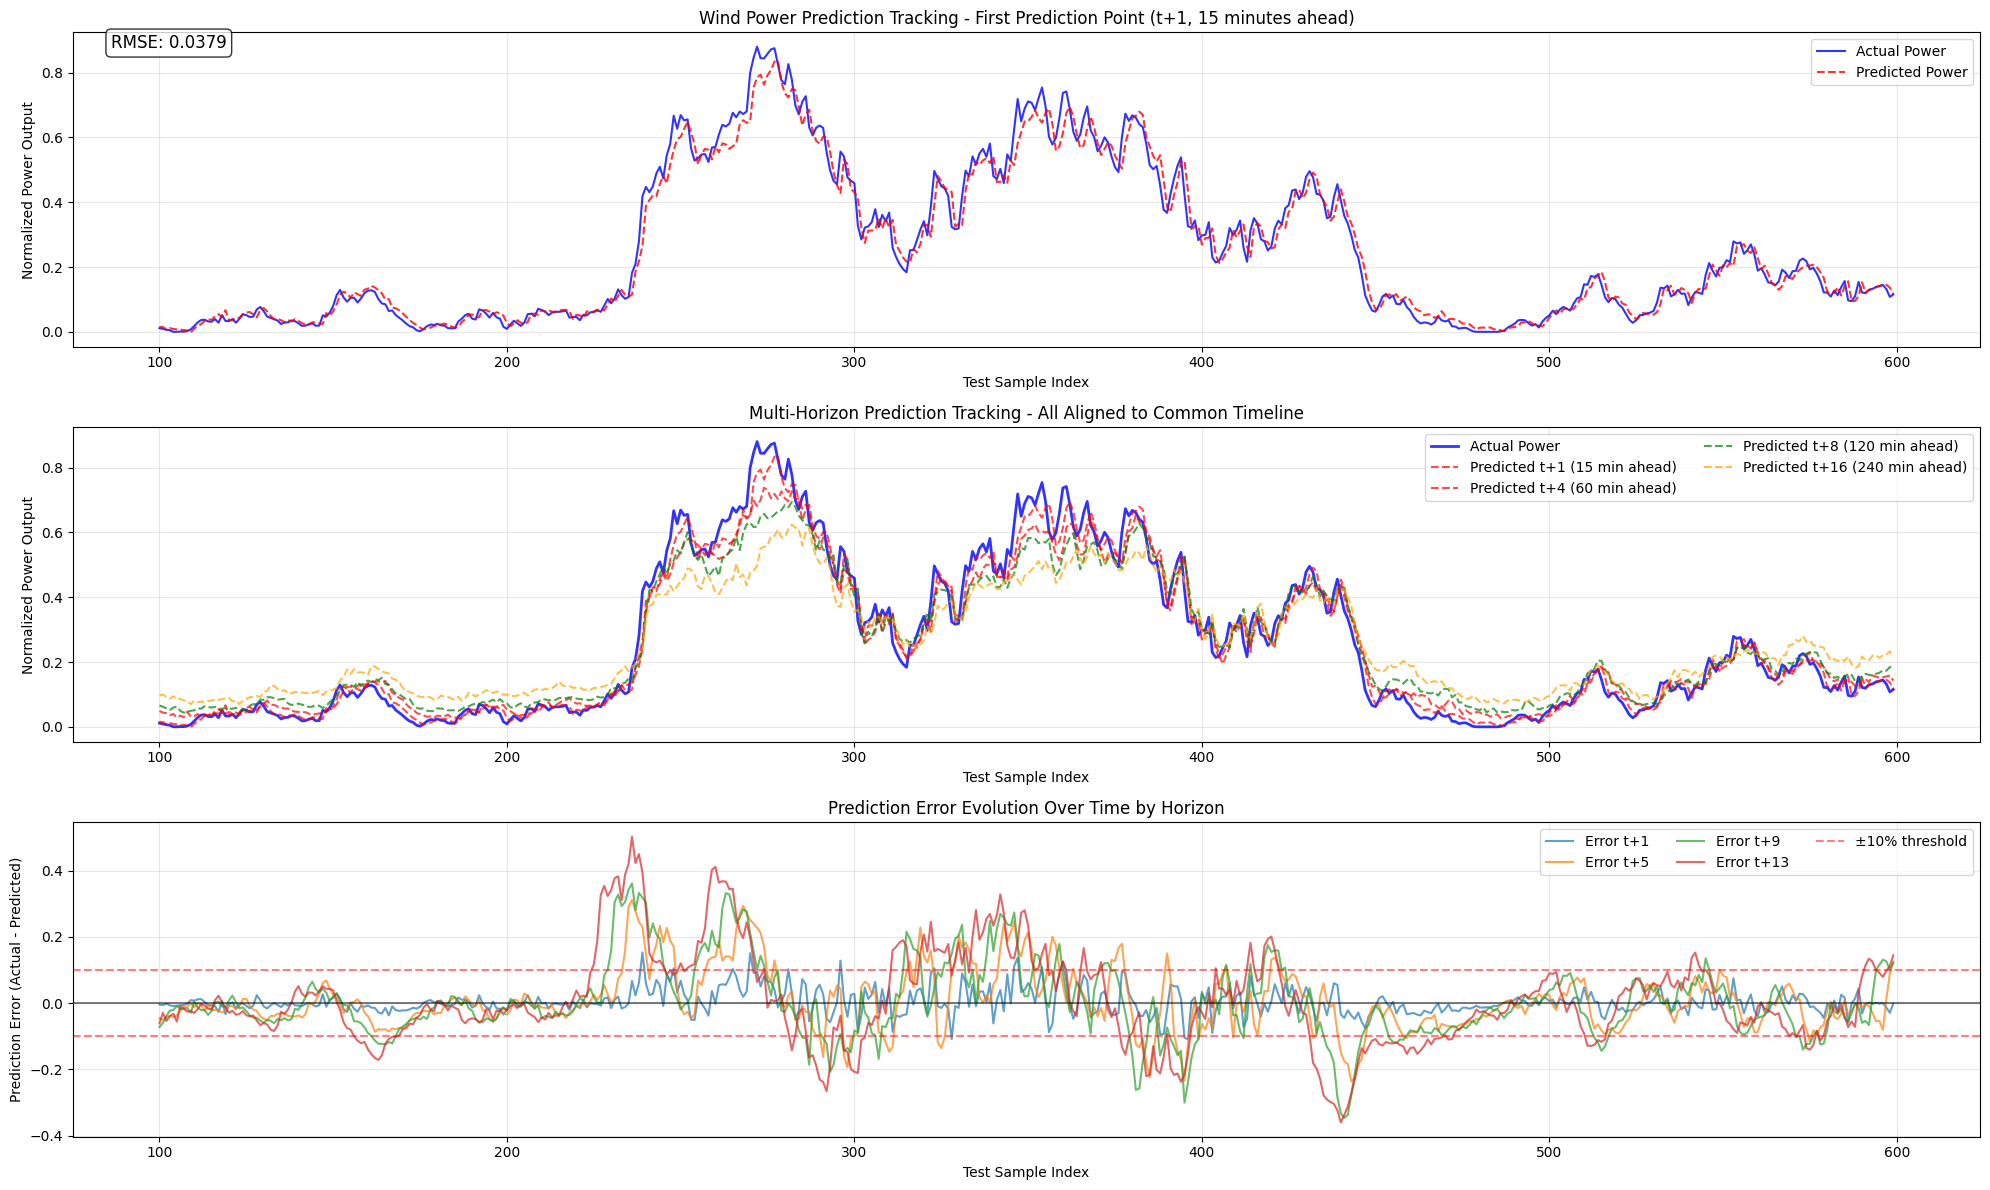

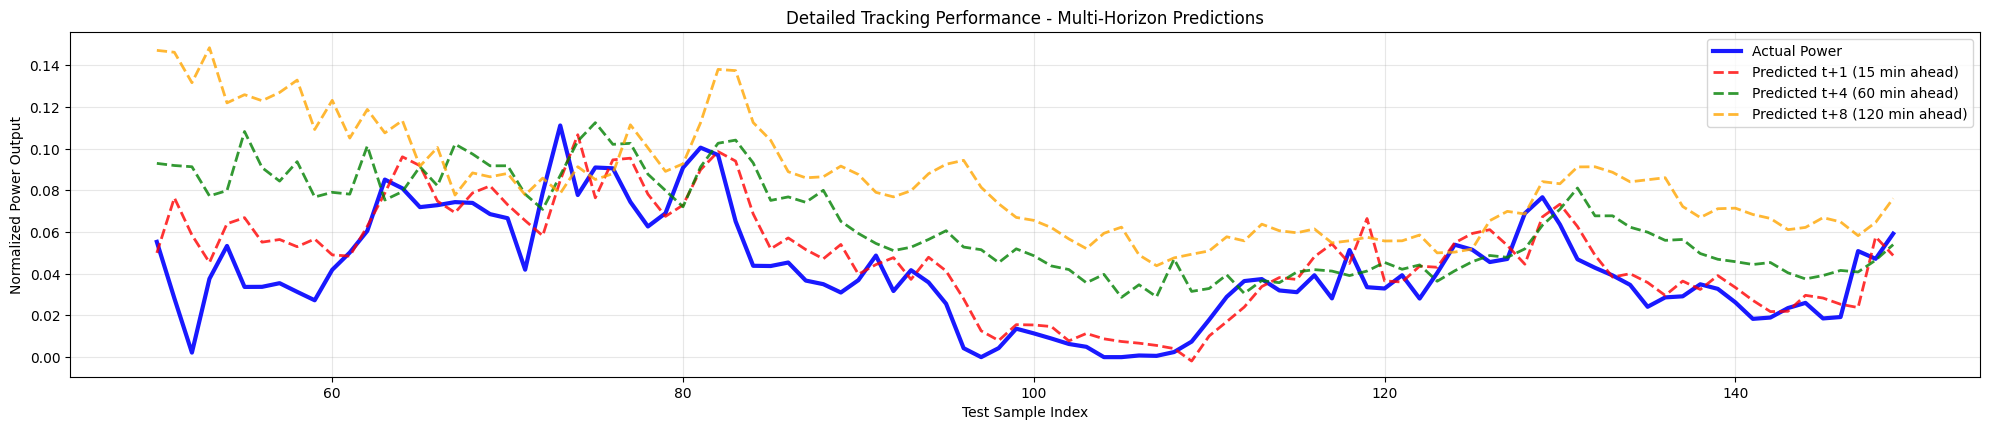

Tracking visualizations saved to /data/jinming/ee_prediction/catboost/results
Shown segment: samples 100 to 600
Overall tracking RMSE (t+1): 0.0379
Note: All predictions are aligned to the same timeline for comparison


In [9]:
# Create comprehensive time series visualization for test set tracking
plt.figure(figsize=(20, 12))

# Select a continuous segment from test set to show tracking performance
start_idx = 100  # Start from beginning of test set
segment_length = min(500, len(y_test))  # Show first 500 samples or all if less

# Create time axis for the segment
time_axis = np.arange(start_idx, start_idx + segment_length)

# Plot 1: Overall tracking performance for first prediction point
plt.subplot(3, 1, 1)

# For visualization, we'll show the tracking for the first prediction point (t+1)
actual_series = y_test[start_idx:start_idx + segment_length, 0]  # First prediction point
predicted_series = test_predictions[start_idx:start_idx + segment_length, 0]

plt.plot(time_axis, actual_series, 'b-', linewidth=1.5, label='Actual Power', alpha=0.8)
plt.plot(time_axis, predicted_series, 'r--', linewidth=1.5, label='Predicted Power', alpha=0.8)
plt.title('Wind Power Prediction Tracking - First Prediction Point (t+1, 15 minutes ahead)')
plt.xlabel('Test Sample Index')
plt.ylabel('Normalized Power Output')
plt.legend()
plt.grid(alpha=0.3)

# Add RMSE annotation
rmse_segment = np.sqrt(mean_squared_error(actual_series, predicted_series))
plt.text(0.02, 0.95, f'RMSE: {rmse_segment:.4f}', transform=plt.gca().transAxes, 
         fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Multi-horizon tracking with time alignment
plt.subplot(3, 1, 2)
colors = ['blue', 'red', 'green', 'orange']
horizons_to_show = [0, 3, 7, 15]  # Show 1st, 4th, 8th, and 16th prediction points

# Create a common actual power reference line
# Use the actual values that correspond to what each horizon is trying to predict
actual_reference = y_test[start_idx:start_idx + segment_length, 0]
plt.plot(time_axis, actual_reference, color='blue', linestyle='-', linewidth=2, 
         alpha=0.8, label='Actual Power')

# Plot predictions for different horizons
for i, horizon in enumerate(horizons_to_show):
    if horizon == 0:
        # For the first horizon, plot directly
        predicted_h = test_predictions[start_idx:start_idx + segment_length, horizon]
        plt.plot(time_axis, predicted_h, color=colors[i+1], linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Predicted t+{horizon+1} ({(horizon+1)*15} min ahead)')
    else:
        # For other horizons, we need to align properly
        # The prediction at sample i for horizon h should align with actual at sample i
        predicted_h = test_predictions[start_idx:start_idx + segment_length, horizon]
        plt.plot(time_axis, predicted_h, color=colors[i], linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Predicted t+{horizon+1} ({(horizon+1)*15} min ahead)')

plt.title('Multi-Horizon Prediction Tracking - All Aligned to Common Timeline')
plt.xlabel('Test Sample Index')
plt.ylabel('Normalized Power Output')
plt.legend(ncol=2, loc='upper right')
plt.grid(alpha=0.3)

# Plot 3: Error evolution over time for different horizons
plt.subplot(3, 1, 3)
# Show prediction errors for different horizons
for i, horizon in enumerate(range(0, config.pred_length, 4)):  # Show every 4th horizon
    if horizon < config.pred_length:
        # Calculate errors for this horizon
        actual_h = y_test[start_idx:start_idx + segment_length, horizon]
        predicted_h = test_predictions[start_idx:start_idx + segment_length, horizon]
        errors_h = actual_h - predicted_h
        
        plt.plot(time_axis, errors_h, linewidth=1.5, alpha=0.7, 
                label=f'Error t+{horizon+1}')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='±10% threshold')
plt.axhline(y=-0.1, color='red', linestyle='--', alpha=0.5)
plt.title('Prediction Error Evolution Over Time by Horizon')
plt.xlabel('Test Sample Index')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.legend(ncol=3, loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/test_tracking_performance.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed view: Focus on a shorter segment for better detail
plt.figure(figsize=(20, 8))

# Select a shorter segment for detailed view
detail_start = 50
detail_length = 100
detail_time = np.arange(detail_start, detail_start + detail_length)

plt.subplot(2, 1, 1)
# Show actual power for the first horizon as reference
actual_detail = y_test[detail_start:detail_start + detail_length, 0]
plt.plot(detail_time, actual_detail, 'b-', linewidth=3, alpha=0.9, label='Actual Power')

# Show predicted lines for different horizons
horizons_detail = [0, 3, 7]  # 1st, 4th, 8th prediction points
colors_detail = ['red', 'green', 'orange']

for i, horizon in enumerate(horizons_detail):
    predicted_detail = test_predictions[detail_start:detail_start + detail_length, horizon]
    plt.plot(detail_time, predicted_detail, color=colors_detail[i], linestyle='--', 
            linewidth=2, alpha=0.8,
            label=f'Predicted t+{horizon+1} ({(horizon+1)*15} min ahead)')

plt.title('Detailed Tracking Performance - Multi-Horizon Predictions')
plt.xlabel('Test Sample Index')
plt.ylabel('Normalized Power Output')
plt.legend()
plt.grid(alpha=0.3)



plt.tight_layout()
plt.savefig(f"{config.results_dir}/detailed_tracking_performance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Tracking visualizations saved to {config.results_dir}")
print(f"Shown segment: samples {start_idx} to {start_idx + segment_length}")
print(f"Overall tracking RMSE (t+1): {rmse_segment:.4f}")
print("Note: All predictions are aligned to the same timeline for comparison")


=== SHAP详细分析 ===

--- 模型 1 (t+1) 的详细SHAP分析 ---


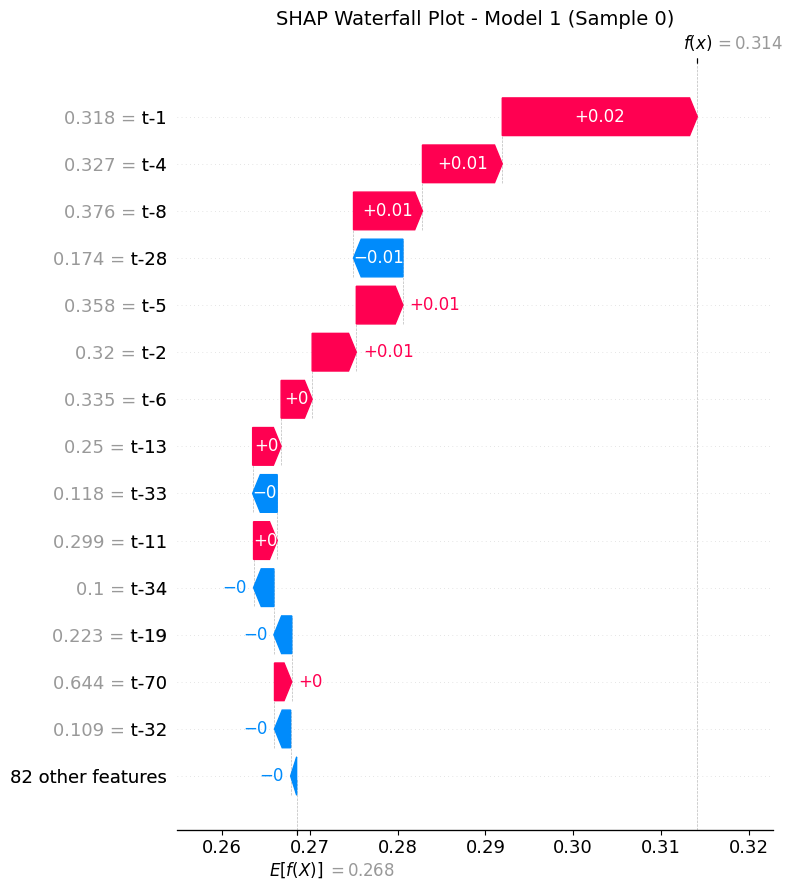

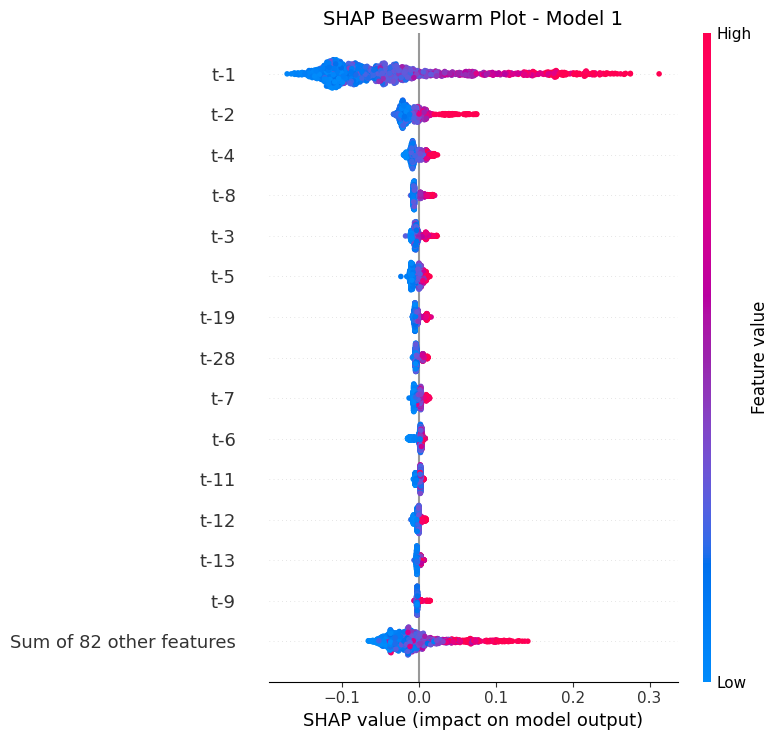


--- 模型 4 (t+4) 的详细SHAP分析 ---


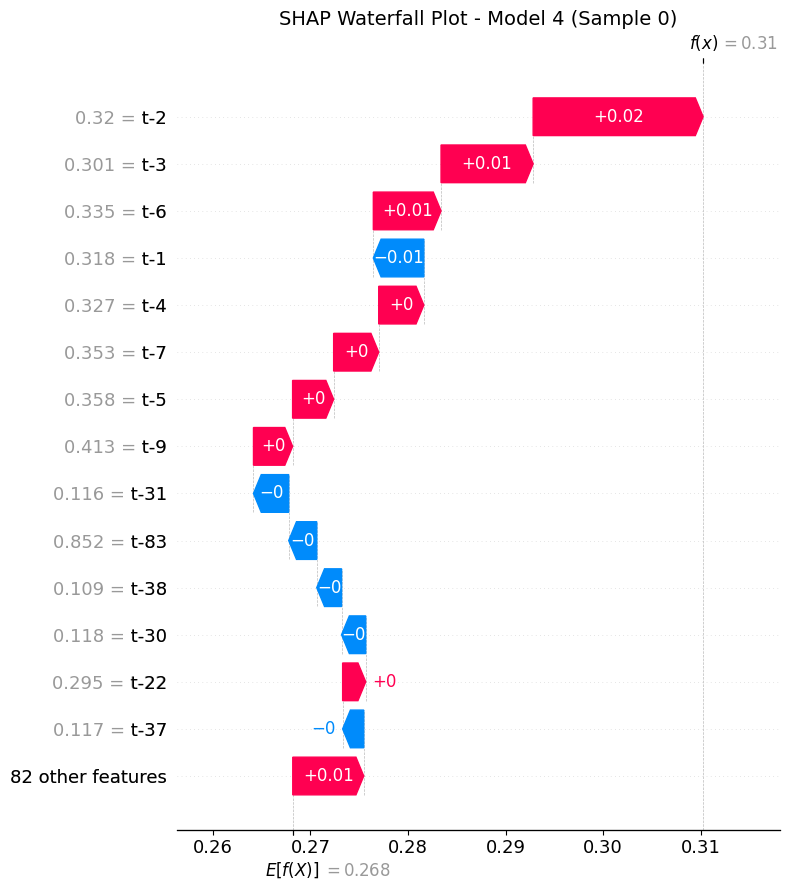

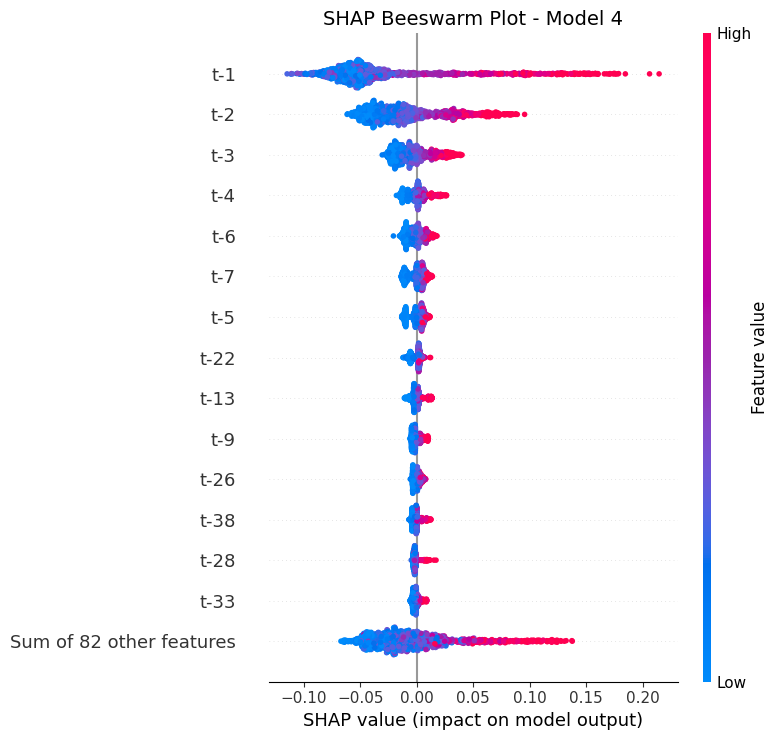


--- 模型 8 (t+8) 的详细SHAP分析 ---


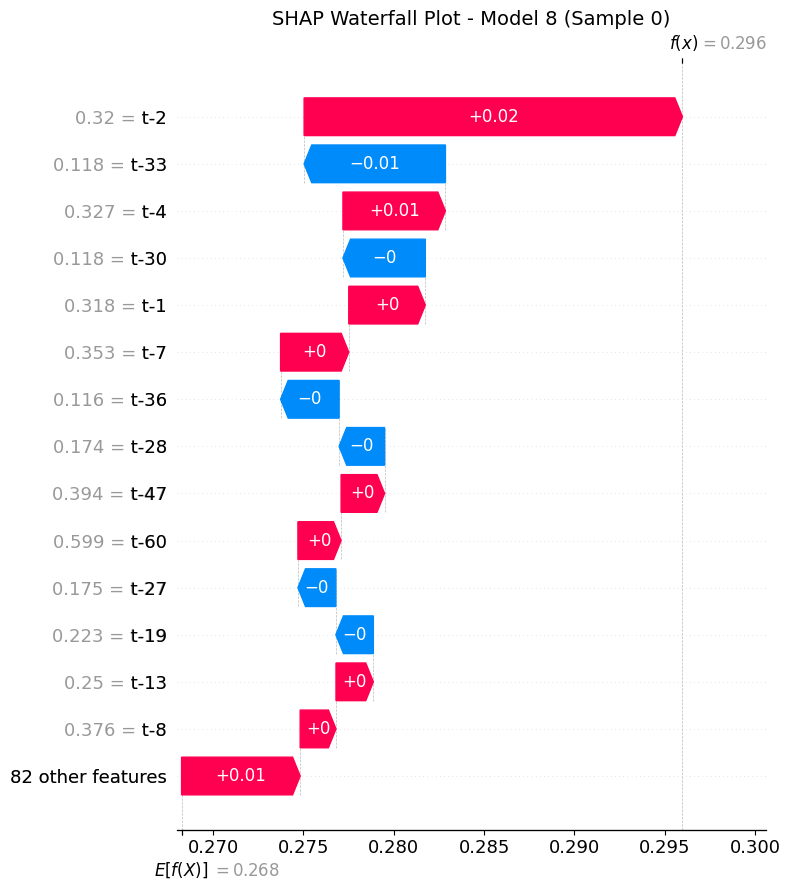

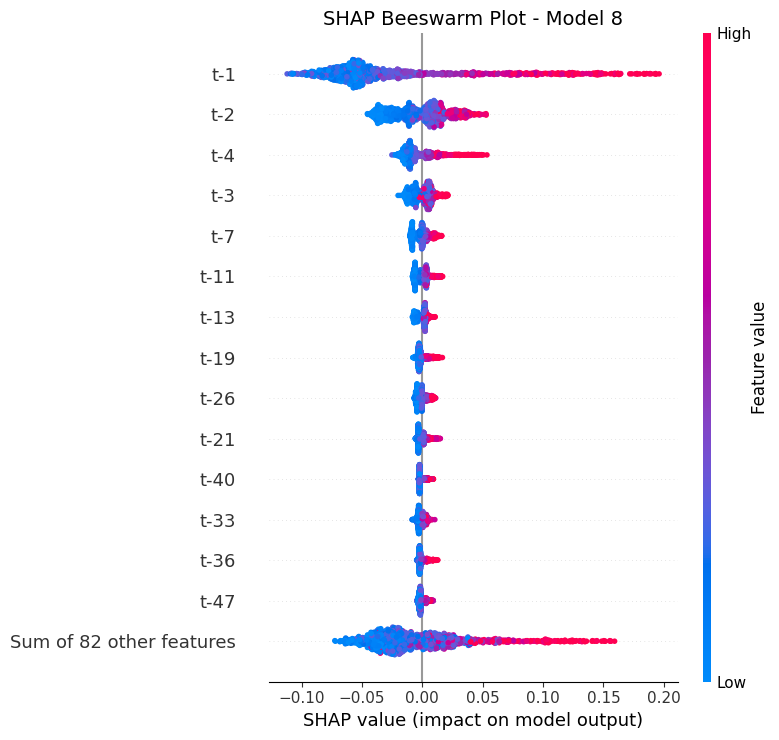


--- 模型 16 (t+16) 的详细SHAP分析 ---


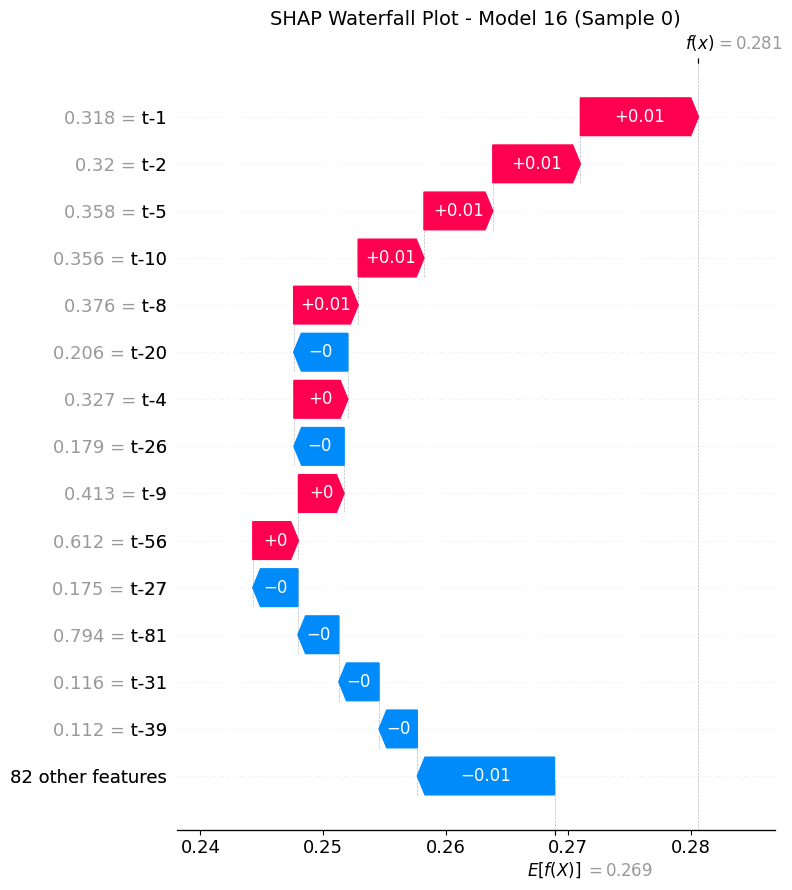

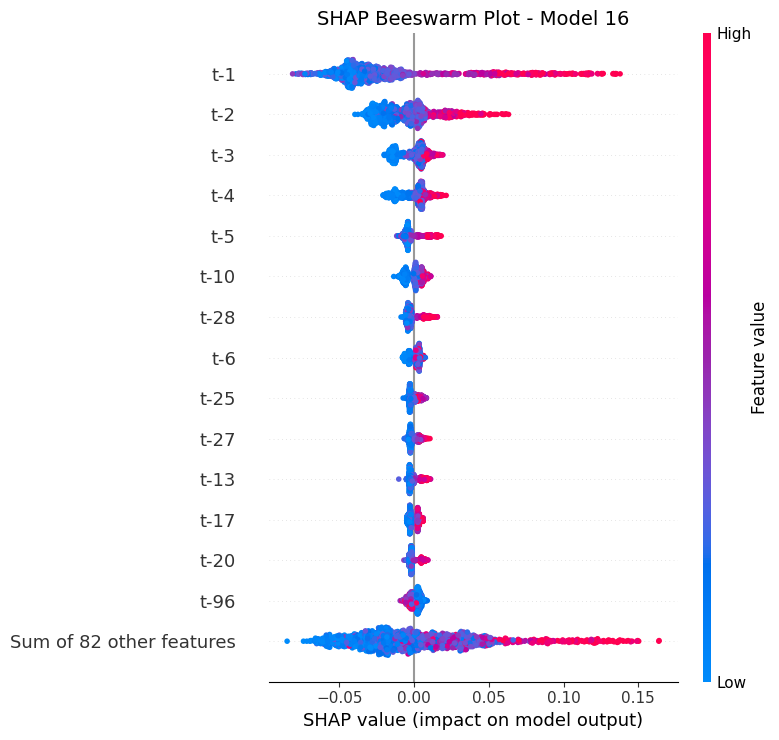


=== 时间序列特征SHAP分析 ===
分析96个时间点的SHAP重要性...


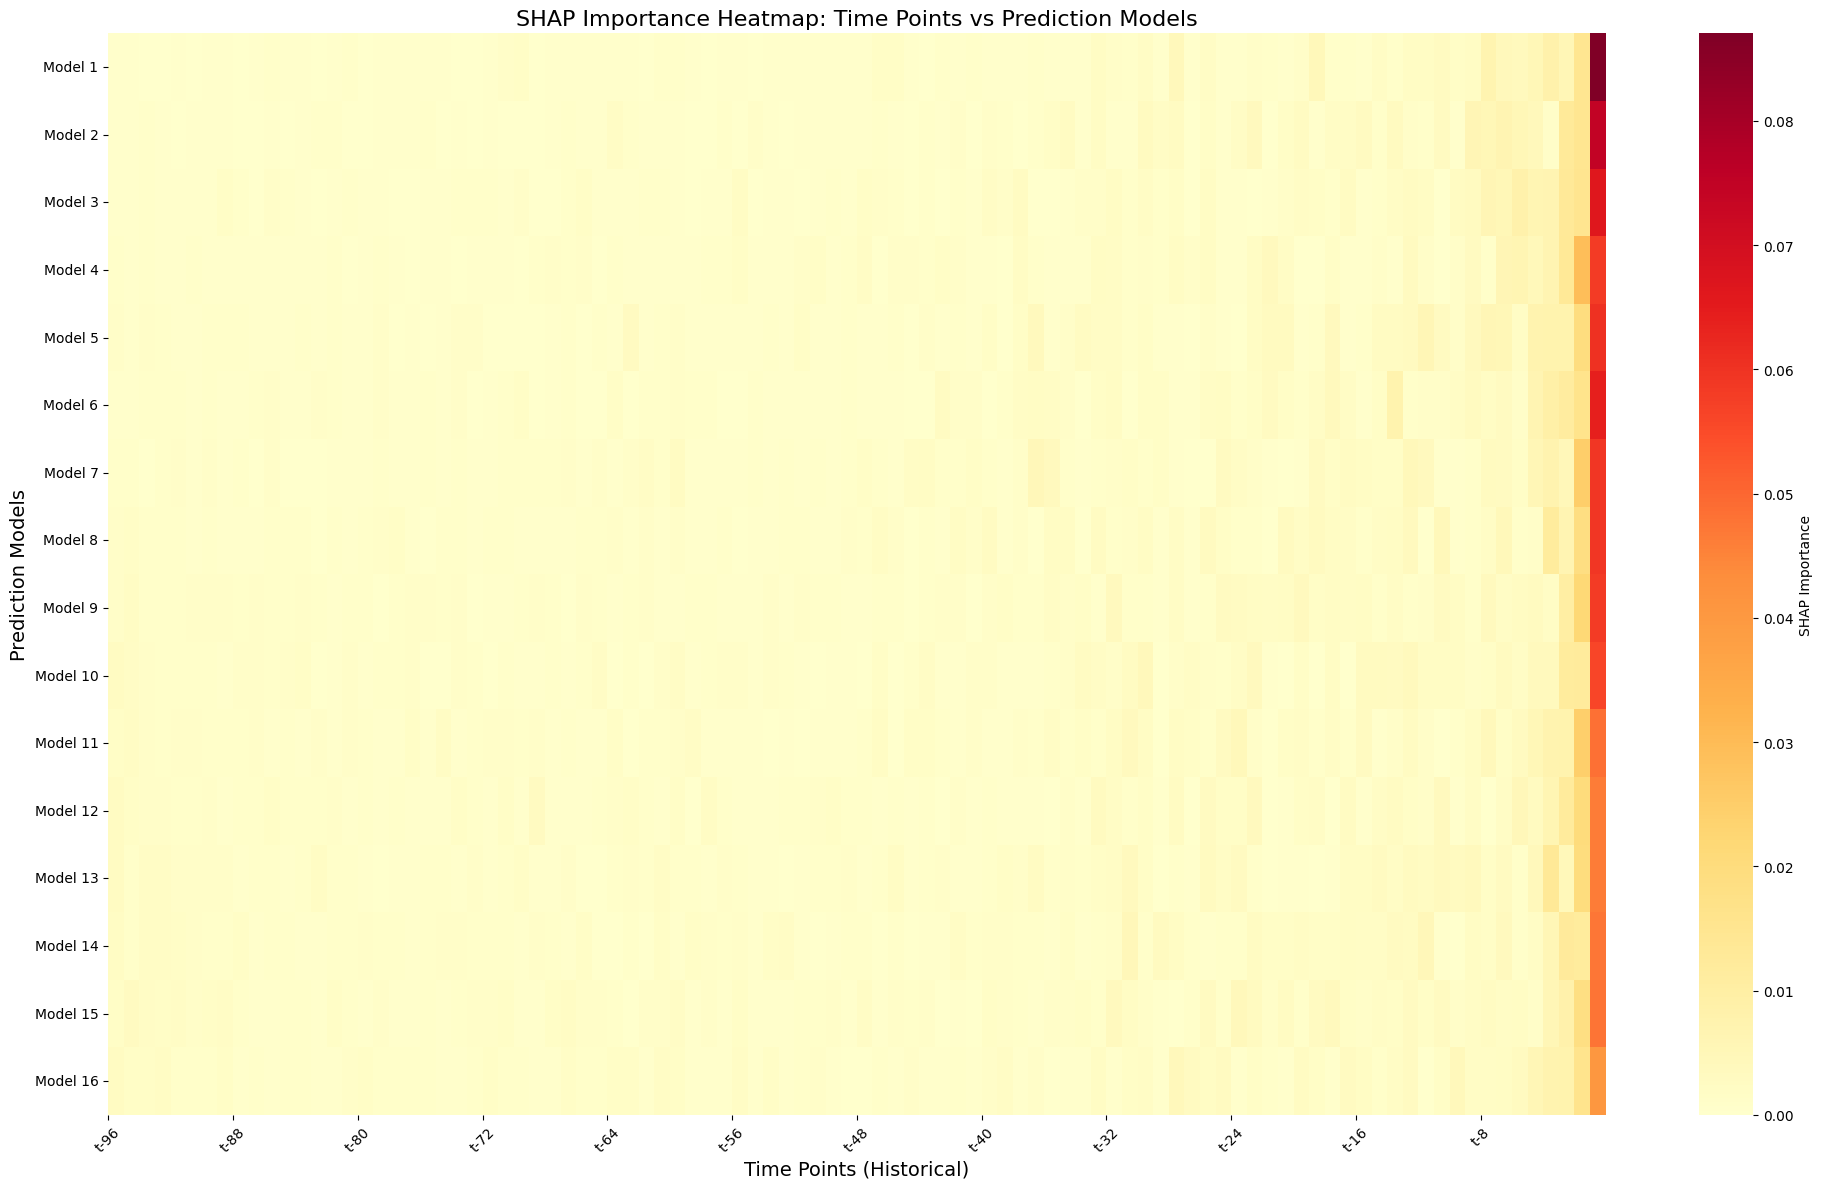


=== 最重要的时间点分析 ===


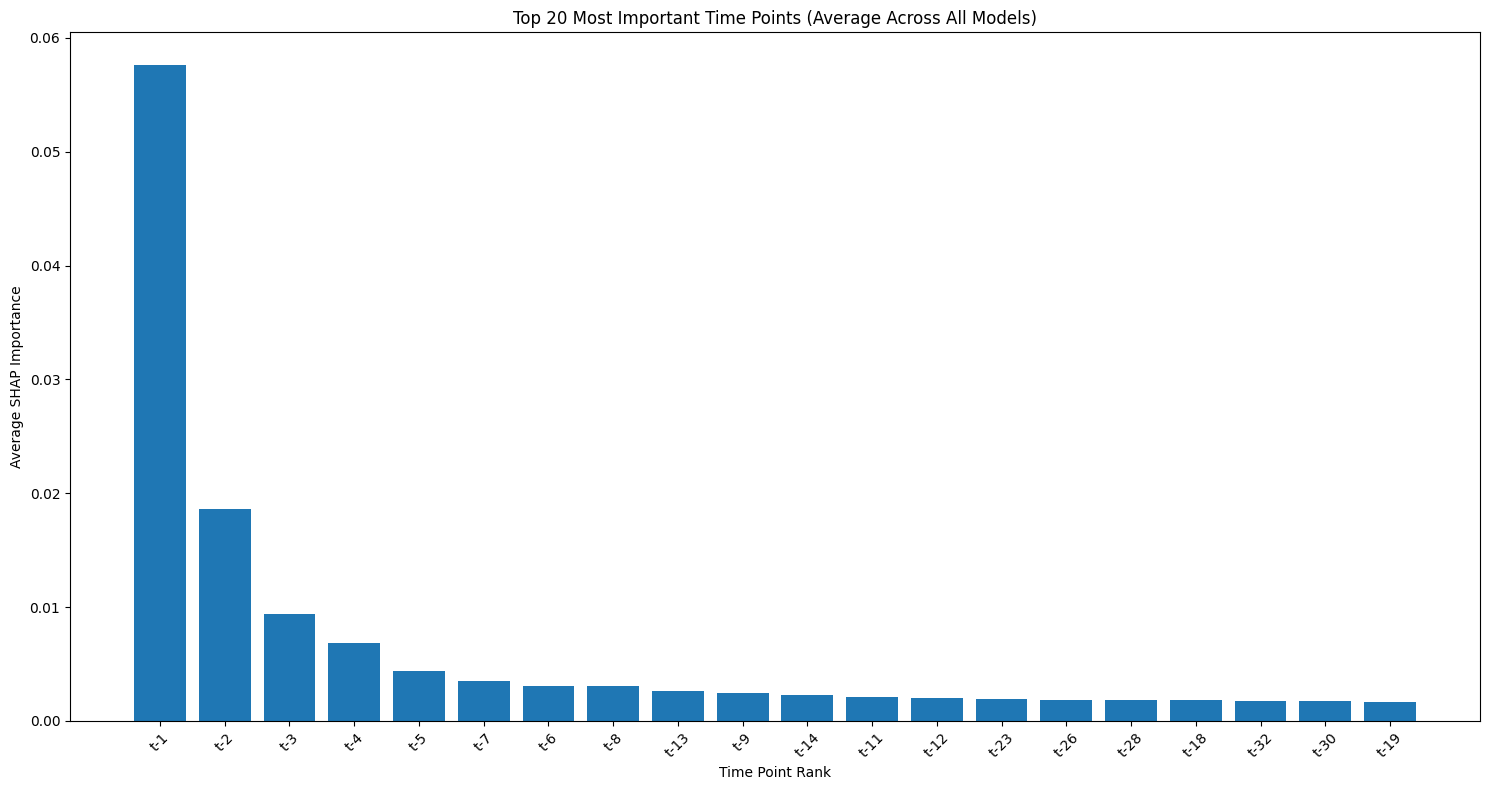

最重要的前10个时间点:
 1.   t-1: 0.057607
 2.   t-2: 0.018627
 3.   t-3: 0.009374
 4.   t-4: 0.006849
 5.   t-5: 0.004412
 6.   t-7: 0.003516
 7.   t-6: 0.003100
 8.   t-8: 0.003086
 9.  t-13: 0.002594
10.   t-9: 0.002462

时间点SHAP分析结果已保存到 /data/jinming/ee_prediction/catboost/results/time_points_shap_analysis.json

SHAP详细分析完成！


In [10]:
# SHAP详细分析 - 深入理解特征贡献
print("\n=== SHAP详细分析 ===")

# 1. 为选定的模型创建详细的SHAP图表
selected_models = [0, 3, 7, 15]  # 选择第1, 4, 8, 16个模型进行详细分析

for model_idx in selected_models:
    print(f"\n--- 模型 {model_idx+1} (t+{model_idx+1}) 的详细SHAP分析 ---")
    
    # SHAP Waterfall Plot - 显示单个预测的特征贡献
    plt.figure(figsize=(12, 8))
    
    # 选择一个具有代表性的样本
    sample_idx = 0
    
    # 创建waterfall plot
    shap.waterfall_plot(
        shap_explanations[model_idx][sample_idx], 
        max_display=15,
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - Model {model_idx+1} (Sample {sample_idx})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/shap_waterfall_model_{model_idx+1}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # SHAP Beeswarm Plot - 显示特征值与SHAP值的关系
    plt.figure(figsize=(12, 8))
    shap.plots.beeswarm(
        shap_explanations[model_idx], 
        max_display=15,
        show=False
    )
    plt.title(f'SHAP Beeswarm Plot - Model {model_idx+1}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/shap_beeswarm_model_{model_idx+1}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 3. 时间序列特征的SHAP分析
print("\n=== 时间序列特征SHAP分析 ===")

# 如果使用的是原始时间序列特征（96个时间点）
if not config.use_feature_engineering or config.use_raw_time_series:
    print("分析96个时间点的SHAP重要性...")
    
    # 为每个模型分析时间点的重要性
    time_point_importance = np.zeros((config.pred_length, config.seq_length))
    
    for i in range(config.pred_length):
        shap_values = shap_values_all_models[i]
        # 计算每个时间点的平均绝对SHAP值
        time_point_importance[i] = np.abs(shap_values).mean(0)
    
    # 创建热力图显示时间点重要性
    plt.figure(figsize=(20, 12))
    
    # 绘制热力图
    sns.heatmap(
        time_point_importance, 
        xticklabels=[f't-{96-i}' for i in range(96)],
        yticklabels=[f'Model {i+1}' for i in range(16)],
        cmap='YlOrRd',
        cbar_kws={'label': 'SHAP Importance'}
    )
    
    plt.title('SHAP Importance Heatmap: Time Points vs Prediction Models', fontsize=16)
    plt.xlabel('Time Points (Historical)', fontsize=14)
    plt.ylabel('Prediction Models', fontsize=14)
    
    # 设置x轴标签，只显示部分标签以避免过于拥挤
    ax = plt.gca()
    ax.set_xticks(range(0, 96, 8))  # 每8个时间点显示一个标签
    ax.set_xticklabels([f't-{96-i}' for i in range(0, 96, 8)], rotation=45)
    
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/time_points_shap_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 分析最重要的时间点
    print("\n=== 最重要的时间点分析 ===")
    
    # 计算每个时间点的平均重要性（跨所有模型）
    avg_time_point_importance = np.mean(time_point_importance, axis=0)
    
    # 找出最重要的时间点
    top_time_points_idx = np.argsort(avg_time_point_importance)[::-1][:20]
    
    plt.figure(figsize=(15, 8))
    plt.bar(range(20), avg_time_point_importance[top_time_points_idx])
    plt.xlabel('Time Point Rank')
    plt.ylabel('Average SHAP Importance')
    plt.title('Top 20 Most Important Time Points (Average Across All Models)')
    
    # 添加时间点标签
    time_labels = [f't-{96-i}' for i in top_time_points_idx]
    plt.xticks(range(20), time_labels, rotation=45)
    
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/top_time_points_importance.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印最重要的时间点
    print("最重要的前10个时间点:")
    for i, idx in enumerate(top_time_points_idx[:10]):
        time_point = f't-{96-idx}'
        importance = avg_time_point_importance[idx]
        print(f"{i+1:2d}. {time_point:>5s}: {importance:.6f}")
    
    # 保存时间点重要性数据
    time_importance_data = {
        'time_points': [f't-{96-i}' for i in range(96)],
        'importance_by_model': time_point_importance.tolist(),
        'average_importance': avg_time_point_importance.tolist(),
        'top_time_points': {
            'indices': top_time_points_idx.tolist(),
            'labels': time_labels,
            'importances': avg_time_point_importance[top_time_points_idx].tolist()
        }
    }
    
    with open(f"{config.results_dir}/time_points_shap_analysis.json", "w") as f:
        json.dump(time_importance_data, f, indent=2)
    
    print(f"\n时间点SHAP分析结果已保存到 {config.results_dir}/time_points_shap_analysis.json")

else:
    print("当前使用特征工程模式，跳过时间序列特征分析")

print("\nSHAP详细分析完成！")


         RMSE和MAE统计分析
整体指标 (所有预测点合并):
  整体RMSE: 0.136874
  整体MAE: 0.098824
  整体CR: 55.94%

各预测点指标的平均值:
  平均RMSE: 0.132369
  平均MAE: 0.098824
  平均CR: 57.61%

RMSE统计:
  最高RMSE: 0.181495 (预测点 t+16)
  最低RMSE: 0.055544 (预测点 t+1)
  RMSE标准差: 0.034828
  RMSE中位数: 0.136520

MAE统计:
  最高MAE: 0.141100 (预测点 t+16)
  最低MAE: 0.035439 (预测点 t+1)
  MAE标准差: 0.029017
  MAE中位数: 0.102403

CR统计:
  最高CR: 83.73% (预测点 t+1)
  最低CR: 40.65% (预测点 t+16)
  CR标准差: 12.00%
  CR中位数: 56.15%

各预测点详细指标:
预测点      时间           RMSE         MAE          CR(%)   
------------------------------------------------------------
t+1      15分钟     0.055544     0.035439     83.73   
t+2      30分钟     0.081173     0.056094     75.48   
t+3      45分钟     0.095145     0.067413     70.75   
t+4      60分钟     0.104345     0.075103     67.34   
t+5      75分钟     0.112843     0.082484     64.54   
t+6      90分钟     0.119118     0.087700     61.95   
t+7      105分钟     0.127090     0.094378     59.17   
t+8      120分钟     0.133992     0.100494  

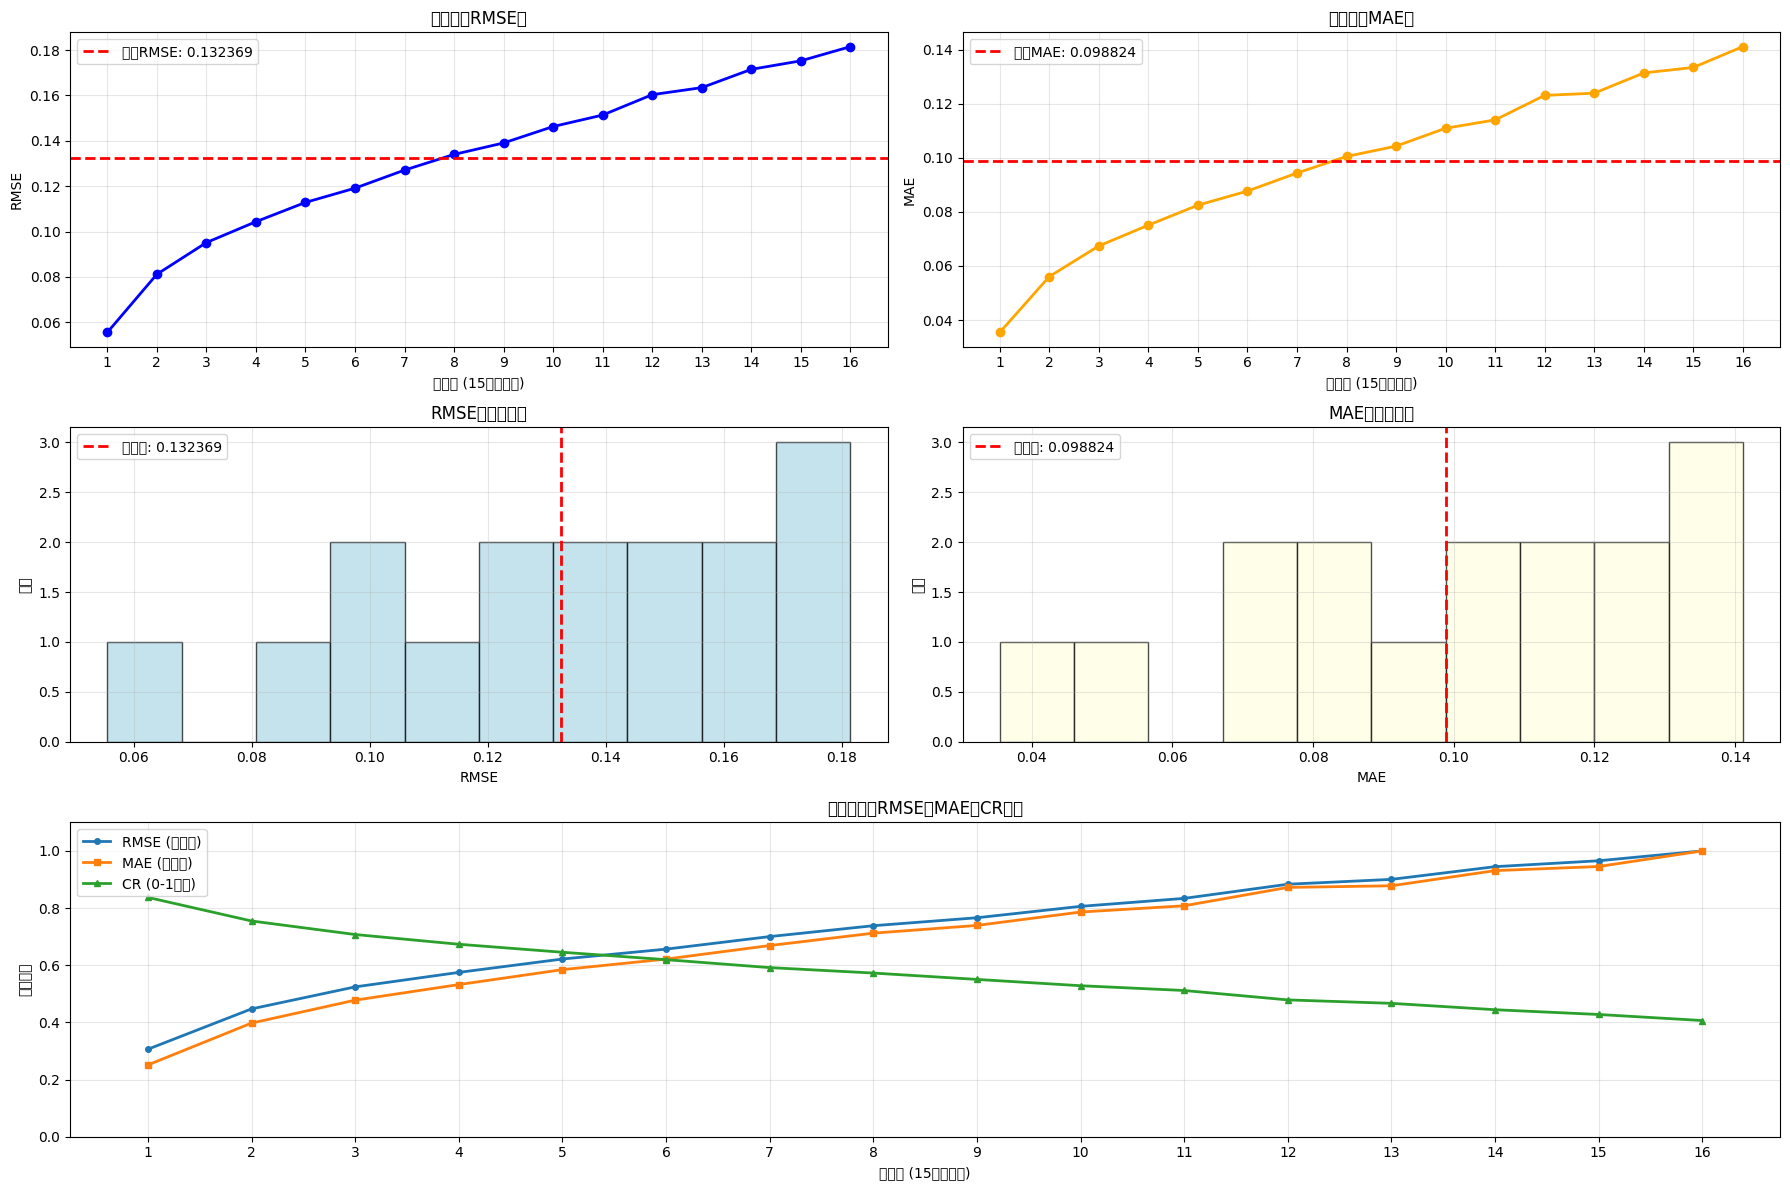


详细指标统计结果已保存到: /data/jinming/ee_prediction/catboost/results/detailed_metrics_statistics.json
可视化结果已保存到: /data/jinming/ee_prediction/catboost/results/rmse_mae_analysis.png


In [11]:
# 计算RMSE和MAE统计分析
print("\n" + "="*60)
print("         RMSE和MAE统计分析")
print("="*60)

# 1. 整体指标
print(f"整体指标 (所有预测点合并):")
print(f"  整体RMSE: {rmse_overall:.6f}")
print(f"  整体MAE: {mae_overall:.6f}")
print(f"  整体CR: {cr_overall:.2f}%")

# 2. 各预测点的平均值
average_rmse = np.mean(step_rmse)
average_mae = np.mean(step_mae)
average_cr = np.mean(step_cr)  # 添加平均CR计算
print(f"\n各预测点指标的平均值:")
print(f"  平均RMSE: {average_rmse:.6f}")
print(f"  平均MAE: {average_mae:.6f}")
print(f"  平均CR: {average_cr:.2f}%")

# 3. 详细统计信息
print(f"\nRMSE统计:")
print(f"  最高RMSE: {np.max(step_rmse):.6f} (预测点 t+{np.argmax(step_rmse)+1})")
print(f"  最低RMSE: {np.min(step_rmse):.6f} (预测点 t+{np.argmin(step_rmse)+1})")
print(f"  RMSE标准差: {np.std(step_rmse):.6f}")
print(f"  RMSE中位数: {np.median(step_rmse):.6f}")

print(f"\nMAE统计:")
print(f"  最高MAE: {np.max(step_mae):.6f} (预测点 t+{np.argmax(step_mae)+1})")
print(f"  最低MAE: {np.min(step_mae):.6f} (预测点 t+{np.argmin(step_mae)+1})")
print(f"  MAE标准差: {np.std(step_mae):.6f}")
print(f"  MAE中位数: {np.median(step_mae):.6f}")

print(f"\nCR统计:")
print(f"  最高CR: {np.max(step_cr):.2f}% (预测点 t+{np.argmax(step_cr)+1})")
print(f"  最低CR: {np.min(step_cr):.2f}% (预测点 t+{np.argmin(step_cr)+1})")
print(f"  CR标准差: {np.std(step_cr):.2f}%")
print(f"  CR中位数: {np.median(step_cr):.2f}%")

# 4. 计算趋势（添加缺失的变量）
# 计算RMSE和CR随预测时间的变化趋势
x_trend = np.arange(1, config.pred_length + 1)
rmse_trend = np.polyfit(x_trend, step_rmse, 1)[0]  # 线性回归斜率
cr_trend = np.polyfit(x_trend, step_cr, 1)[0]      # 线性回归斜率


# 5. 显示每个预测点的详细指标
print(f"\n各预测点详细指标:")
print(f"{'预测点':<8} {'时间':<12} {'RMSE':<12} {'MAE':<12} {'CR(%)':<8}")
print("-" * 60)
for i in range(config.pred_length):
    print(f"t+{i+1:<6} {(i+1)*15}分钟     {step_rmse[i]:<12.6f} {step_mae[i]:<12.6f} {step_cr[i]:<8.2f}")

# 6. 可视化RMSE、MAE和CR的分布
plt.figure(figsize=(18, 12))

# RMSE随预测时间的变化
plt.subplot(3, 2, 1)
plt.plot(range(1, config.pred_length+1), step_rmse, 'o-', color='blue', linewidth=2, markersize=6)
plt.axhline(y=average_rmse, color='red', linestyle='--', linewidth=2, 
            label=f'平均RMSE: {average_rmse:.6f}')
plt.title('各预测点RMSE值')
plt.xlabel('预测点 (15分钟间隔)')
plt.ylabel('RMSE')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.legend()

# MAE随预测时间的变化
plt.subplot(3, 2, 2)
plt.plot(range(1, config.pred_length+1), step_mae, 'o-', color='orange', linewidth=2, markersize=6)
plt.axhline(y=average_mae, color='red', linestyle='--', linewidth=2, 
            label=f'平均MAE: {average_mae:.6f}')
plt.title('各预测点MAE值')
plt.xlabel('预测点 (15分钟间隔)')
plt.ylabel('MAE')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.legend()

# RMSE分布直方图
plt.subplot(3, 2, 3)
plt.hist(step_rmse, bins=10, color='lightblue', alpha=0.7, edgecolor='black')
plt.axvline(x=average_rmse, color='red', linestyle='--', linewidth=2, 
            label=f'平均值: {average_rmse:.6f}')
plt.title('RMSE分布直方图')
plt.xlabel('RMSE')
plt.ylabel('频次')
plt.legend()
plt.grid(alpha=0.3)

# MAE分布直方图
plt.subplot(3, 2, 4)
plt.hist(step_mae, bins=10, color='lightyellow', alpha=0.7, edgecolor='black')
plt.axvline(x=average_mae, color='red', linestyle='--', linewidth=2, 
            label=f'平均值: {average_mae:.6f}')
plt.title('MAE分布直方图')
plt.xlabel('MAE')
plt.ylabel('频次')
plt.legend()
plt.grid(alpha=0.3)

# 三个指标的综合比较
plt.subplot(3, 1, 3)
# 标准化指标以便在同一图上显示
rmse_normalized = np.array(step_rmse) / np.max(step_rmse)
mae_normalized = np.array(step_mae) / np.max(step_mae)
cr_normalized = np.array(step_cr) / 100  # CR已经是百分比

x_points = range(1, config.pred_length+1)
plt.plot(x_points, rmse_normalized, 'o-', label='RMSE (标准化)', linewidth=2, markersize=4)
plt.plot(x_points, mae_normalized, 's-', label='MAE (标准化)', linewidth=2, markersize=4)
plt.plot(x_points, cr_normalized, '^-', label='CR (0-1缩放)', linewidth=2, markersize=4)

plt.title('标准化后的RMSE、MAE和CR对比')
plt.xlabel('预测点 (15分钟间隔)')
plt.ylabel('标准化值')
plt.grid(alpha=0.3)
plt.xticks(range(1, config.pred_length+1))
plt.legend()
plt.ylim(0, 1.1)

plt.tight_layout()
plt.savefig(f"{config.results_dir}/rmse_mae_analysis.png", dpi=300)
plt.show()

# 7. 保存详细统计结果
detailed_stats = {
    'overall_metrics': {
        'rmse': float(rmse_overall),
        'mae': float(mae_overall),
        'cr': float(cr_overall)
    },
    'average_metrics': {
        'rmse': float(average_rmse),
        'mae': float(average_mae),
        'cr': float(average_cr)
    },
    'rmse_stats': {
        'max': float(np.max(step_rmse)),
        'min': float(np.min(step_rmse)),
        'std': float(np.std(step_rmse)),
        'median': float(np.median(step_rmse)),
        'max_at_point': int(np.argmax(step_rmse) + 1),
        'min_at_point': int(np.argmin(step_rmse) + 1)
    },
    'mae_stats': {
        'max': float(np.max(step_mae)),
        'min': float(np.min(step_mae)),
        'std': float(np.std(step_mae)),
        'median': float(np.median(step_mae)),
        'max_at_point': int(np.argmax(step_mae) + 1),
        'min_at_point': int(np.argmin(step_mae) + 1)
    },
    'cr_stats': {
        'max': float(np.max(step_cr)),
        'min': float(np.min(step_cr)),
        'std': float(np.std(step_cr)),
        'median': float(np.median(step_cr)),
        'max_at_point': int(np.argmax(step_cr) + 1),
        'min_at_point': int(np.argmin(step_cr) + 1)
    },
    'trend_analysis': {
        'rmse_trend_slope': float(rmse_trend),
        'cr_trend_slope': float(cr_trend)
    },
    'individual_values': {
        'rmse': [float(x) for x in step_rmse],
        'mae': [float(x) for x in step_mae],
        'cr': [float(x) for x in step_cr]
    }
}

with open(f"{config.results_dir}/detailed_metrics_statistics.json", "w") as f:
    json.dump(detailed_stats, f, indent=2)

print(f"\n详细指标统计结果已保存到: {config.results_dir}/detailed_metrics_statistics.json")
print(f"可视化结果已保存到: {config.results_dir}/rmse_mae_analysis.png")

# 两阶段训练：基于SHAP的特征选择

接下来实现两阶段训练流程：
1. **第一阶段**：使用所有96个时间点特征训练模型并进行SHAP分析（已完成）
2. **第二阶段**：基于SHAP分析结果，为每个模型选择最重要的4个特征，重新训练模型

这种方法的优势：
- 减少特征维度，降低过拟合风险
- 提高训练和推理速度
- 保持模型性能的同时降低内存需求
- 每个模型使用最适合的特征组合

In [12]:
# ===== 第二阶段：基于SHAP的特征选择 =====

if config.enable_shap_feature_selection and config.enable_two_stage_training:
    print("="*80)
    print("                    开始第二阶段训练：基于SHAP的特征选择")
    print("="*80)
    
    # 1. 提取每个模型的top-k重要特征
    selected_features_per_model = {}
    selected_feature_names_per_model = {}
    
    print(f"\n为每个模型选择前{config.shap_selected_features}个最重要的特征...")
    
    for i in range(config.pred_length):
        # 获取第i个模型的SHAP值
        shap_values = shap_values_all_models[i]
        
        # 计算每个特征的平均绝对SHAP值作为重要性分数
        feature_importance_shap = np.abs(shap_values).mean(0)
        
        # 获取top-k重要特征的索引
        top_k_indices = np.argsort(feature_importance_shap)[::-1][:config.shap_selected_features]
        top_k_indices = np.sort(top_k_indices)  # 保持时间顺序
        
        # 保存选择的特征索引和名称
        selected_features_per_model[f'model_{i+1}'] = top_k_indices.tolist()
        selected_feature_names_per_model[f'model_{i+1}'] = [feature_names[idx] for idx in top_k_indices]
        
        # 显示选择的特征
        selected_shap_scores = feature_importance_shap[top_k_indices]
        print(f"\n模型 {i+1} (t+{i+1}) 选择的特征:")
        for j, (idx, score) in enumerate(zip(top_k_indices, selected_shap_scores)):
            print(f"  {j+1:2d}. {feature_names[idx]:6s} (SHAP重要性: {score:.6f})")
    
    # 保存特征选择结果
    feature_selection_results = {
        'config': {
            'total_features': len(feature_names),
            'selected_features_per_model': config.shap_selected_features,
            'selection_method': 'SHAP',
            'shap_sample_size': len(X_shap)
        },
        'selected_features_per_model': selected_features_per_model,
        'selected_feature_names_per_model': selected_feature_names_per_model
    }
    
    with open(f"{config.results_dir}/stage2_feature_selection.json", "w") as f:
        json.dump(feature_selection_results, f, indent=2)
    
    print(f"\n特征选择结果已保存到: {config.results_dir}/stage2_feature_selection.json")
    
else:
    print("跳过两阶段训练（未启用或SHAP特征选择未启用）")

                    开始第二阶段训练：基于SHAP的特征选择

为每个模型选择前8个最重要的特征...

模型 1 (t+1) 选择的特征:
   1. t-28   (SHAP重要性: 0.004210)
   2. t-19   (SHAP重要性: 0.004542)
   3. t-8    (SHAP重要性: 0.006831)
   4. t-5    (SHAP重要性: 0.005392)
   5. t-4    (SHAP重要性: 0.008455)
   6. t-3    (SHAP重要性: 0.005635)
   7. t-2    (SHAP重要性: 0.014808)
   8. t-1    (SHAP重要性: 0.087053)

模型 2 (t+2) 选择的特征:
   1. t-9    (SHAP重要性: 0.006101)
   2. t-8    (SHAP重要性: 0.005254)
   3. t-7    (SHAP重要性: 0.006560)
   4. t-6    (SHAP重要性: 0.005361)
   5. t-5    (SHAP重要性: 0.004235)
   6. t-3    (SHAP重要性: 0.012920)
   7. t-2    (SHAP重要性: 0.014896)
   8. t-1    (SHAP重要性: 0.074710)

模型 3 (t+3) 选择的特征:
   1. t-8    (SHAP重要性: 0.006027)
   2. t-7    (SHAP重要性: 0.005182)
   3. t-6    (SHAP重要性: 0.008311)
   4. t-5    (SHAP重要性: 0.006330)
   5. t-4    (SHAP重要性: 0.006473)
   6. t-3    (SHAP重要性: 0.013060)
   7. t-2    (SHAP重要性: 0.015134)
   8. t-1    (SHAP重要性: 0.066471)

模型 4 (t+4) 选择的特征:
   1. t-22   (SHAP重要性: 0.003409)
   2. t-7    (SHAP重要性: 0.005949)
   3

In [13]:
# ===== 第二阶段：准备特征选择后的数据 =====

if config.enable_shap_feature_selection and config.enable_two_stage_training:
    print("\n" + "="*60)
    print("                准备第二阶段训练数据")
    print("="*60)
    
    # 为每个模型创建特征选择后的数据集
    X_train_split_stage2 = []
    X_val_stage2 = []
    X_test_stage2 = []
    
    for i in range(config.pred_length):
        # 获取第i个模型选择的特征索引
        selected_indices = selected_features_per_model[f'model_{i+1}']
        
        # 选择对应的特征列
        X_train_model_i = X_train_split[:, selected_indices]
        X_val_model_i = X_val[:, selected_indices] 
        X_test_model_i = X_test[:, selected_indices]
        
        X_train_split_stage2.append(X_train_model_i)
        X_val_stage2.append(X_val_model_i)
        X_test_stage2.append(X_test_model_i)
        
        print(f"模型 {i+1}: 原始特征 {X_train_split.shape[1]} -> 选择特征 {X_train_model_i.shape[1]}")
    
    print(f"\n第二阶段数据准备完成！")
    print(f"训练集样本数: {len(X_train_split_stage2[0])}")
    print(f"验证集样本数: {len(X_val_stage2[0])}")
    print(f"测试集样本数: {len(X_test_stage2[0])}")


                准备第二阶段训练数据
模型 1: 原始特征 96 -> 选择特征 8
模型 2: 原始特征 96 -> 选择特征 8
模型 3: 原始特征 96 -> 选择特征 8
模型 4: 原始特征 96 -> 选择特征 8
模型 5: 原始特征 96 -> 选择特征 8
模型 6: 原始特征 96 -> 选择特征 8
模型 7: 原始特征 96 -> 选择特征 8
模型 8: 原始特征 96 -> 选择特征 8
模型 9: 原始特征 96 -> 选择特征 8
模型 10: 原始特征 96 -> 选择特征 8
模型 11: 原始特征 96 -> 选择特征 8
模型 12: 原始特征 96 -> 选择特征 8
模型 13: 原始特征 96 -> 选择特征 8
模型 14: 原始特征 96 -> 选择特征 8
模型 15: 原始特征 96 -> 选择特征 8
模型 16: 原始特征 96 -> 选择特征 8

第二阶段数据准备完成！
训练集样本数: 5510
验证集样本数: 1378
测试集样本数: 2888


In [14]:
# ===== 第二阶段：训练函数定义 =====

def train_single_model_stage2(model_idx, X_train_model, y_train_split, X_val_model, y_val, config, selected_feature_names):
    """
    第二阶段训练：使用选择的特征训练单个CatBoost模型
    
    参数:
    model_idx: 模型索引（0-15）
    X_train_model: 当前模型的训练特征（已选择特征）
    y_train_split: 训练目标
    X_val_model: 当前模型的验证特征（已选择特征）
    y_val: 验证目标
    config: 配置对象
    selected_feature_names: 选择的特征名称列表
    
    返回:
    model: 训练好的模型
    metrics: 训练指标
    model_idx: 模型索引
    """
    # 为当前时间点创建CatBoost模型
    model = CatBoostRegressor(
        iterations=config.n_estimators,
        learning_rate=config.learning_rate,
        depth=config.max_depth,
        l2_leaf_reg=config.l2_leaf_reg,
        random_strength=config.random_strength,
        bagging_temperature=config.bagging_temperature,
        od_type=config.od_type,
        od_wait=config.od_wait,
        verbose=False,  # 关闭详细输出以避免并行时的混乱
        random_seed=config.random_seed + model_idx + 1000,  # 为第二阶段设置不同的随机种子
        task_type=config.task_type
    )
    
    # 训练模型
    model.fit(
        X_train_model, y_train_split[:, model_idx],
        eval_set=[(X_val_model, y_val[:, model_idx])],
        use_best_model=True,
        early_stopping_rounds=config.od_wait,
        verbose=False  # 关闭详细输出
    )
    
    # 在验证集上评估
    val_pred = model.predict(X_val_model)
    val_metrics = calculate_metrics(y_val[:, model_idx], val_pred)
    
    # 保存模型（第二阶段模型使用不同的命名）
    model_path = f"{config.model_save_dir}/catboost_stage2_point_{model_idx+1}.cbm"
    model.save_model(model_path)
    
    # 返回结果
    metrics = {
        'horizon': model_idx+1,
        'selected_features': len(selected_feature_names),
        'selected_feature_names': selected_feature_names,
        'best_iteration': model.best_iteration_,
        'train_rmse': model.get_best_score()['learn']['RMSE'],
        'val_rmse': model.get_best_score()['validation']['RMSE'],
        'val_custom_metrics': val_metrics
    }
    
    return model, metrics, model_idx

print("第二阶段训练函数定义完成！")

第二阶段训练函数定义完成！


In [15]:
# ===== 第二阶段：执行训练 =====

if config.enable_shap_feature_selection and config.enable_two_stage_training:
    print("\n" + "="*60)
    print("              开始第二阶段模型训练")
    print("="*60)
    
    models_stage2 = []
    training_metrics_stage2 = []
    
    print(f"训练{config.pred_length}个CatBoost模型（第二阶段）...")
    
    if config.use_parallel_training:
        print(f"使用并行训练，进程数: {config.max_processes}")
        
        # 创建进程池
        with ProcessPool(processes=config.max_processes) as pool:
            # 准备并行训练任务
            train_tasks_stage2 = []
            for i in range(config.pred_length):
                # 获取当前模型的特征选择后的数据和特征名称
                X_train_model = X_train_split_stage2[i]
                X_val_model = X_val_stage2[i]
                selected_feature_names = selected_feature_names_per_model[f'model_{i+1}']
                
                # 使用 partial 函数来固定参数
                task = partial(
                    train_single_model_stage2,
                    i, X_train_model, y_train_split, X_val_model, y_val, config, selected_feature_names
                )
                train_tasks_stage2.append(task)
            
            # 执行并行训练
            print("开始第二阶段并行训练...")
            results_stage2 = []
            for i, task in enumerate(train_tasks_stage2):
                print(f"提交模型 {i+1} 进行第二阶段训练...")
                result = pool.apply_async(task)
                results_stage2.append(result)
            
            # 收集结果
            trained_models_stage2 = [None] * config.pred_length
            all_metrics_stage2 = [None] * config.pred_length
            
            print("等待第二阶段训练完成...")
            for i, result in enumerate(results_stage2):
                try:
                    model, metrics, model_idx = result.get(timeout=3600)  # 1小时超时
                    trained_models_stage2[model_idx] = model
                    all_metrics_stage2[model_idx] = metrics
                    print(f"模型 {model_idx+1} 第二阶段完成: Val RMSE = {metrics['val_custom_metrics']['rmse']:.6f}, Val CR = {metrics['val_custom_metrics']['cr']:.2f}%, 特征数 = {metrics['selected_features']}")
                except Exception as e:
                    print(f"第二阶段训练模型 {i+1} 时出错: {e}")
                    raise
            
            # 将结果赋值给变量
            models_stage2 = trained_models_stage2
            training_metrics_stage2 = all_metrics_stage2
            
    else:
        # 顺序训练（作为备选方案）
        print("使用顺序训练")
        for i in tqdm(range(config.pred_length), desc="第二阶段训练模型"):
            X_train_model = X_train_split_stage2[i]
            X_val_model = X_val_stage2[i]
            selected_feature_names = selected_feature_names_per_model[f'model_{i+1}']
            
            model, metrics, _ = train_single_model_stage2(
                i, X_train_model, y_train_split, X_val_model, y_val, config, selected_feature_names
            )
            models_stage2.append(model)
            training_metrics_stage2.append(metrics)
            print(f"模型 {i+1}: Val RMSE = {metrics['val_custom_metrics']['rmse']:.6f}, Val CR = {metrics['val_custom_metrics']['cr']:.2f}%, 特征数 = {metrics['selected_features']}")
    
    # 保存第二阶段训练指标
    with open(f"{config.results_dir}/stage2_training_metrics.json", "w") as f:
        json.dump(training_metrics_stage2, f, indent=2)
    
    print("第二阶段训练完成并成功保存所有模型。")
    print(f"训练完成，使用{'并行' if config.use_parallel_training else '顺序'}处理。")
    
else:
    print("跳过第二阶段训练")


              开始第二阶段模型训练
训练16个CatBoost模型（第二阶段）...
使用并行训练，进程数: 2
开始第二阶段并行训练...
提交模型 1 进行第二阶段训练...
提交模型 2 进行第二阶段训练...
提交模型 3 进行第二阶段训练...
提交模型 4 进行第二阶段训练...
提交模型 5 进行第二阶段训练...
提交模型 6 进行第二阶段训练...
提交模型 7 进行第二阶段训练...
提交模型 8 进行第二阶段训练...
提交模型 9 进行第二阶段训练...
提交模型 10 进行第二阶段训练...
提交模型 11 进行第二阶段训练...
提交模型 12 进行第二阶段训练...
提交模型 13 进行第二阶段训练...
提交模型 14 进行第二阶段训练...
提交模型 15 进行第二阶段训练...
提交模型 16 进行第二阶段训练...
等待第二阶段训练完成...
模型 1 第二阶段完成: Val RMSE = 0.043293, Val CR = 83.87%, 特征数 = 8
模型 2 第二阶段完成: Val RMSE = 0.065023, Val CR = 76.53%, 特征数 = 8
模型 3 第二阶段完成: Val RMSE = 0.075817, Val CR = 72.82%, 特征数 = 8
模型 4 第二阶段完成: Val RMSE = 0.083810, Val CR = 69.51%, 特征数 = 8
模型 5 第二阶段完成: Val RMSE = 0.089660, Val CR = 66.99%, 特征数 = 8
模型 6 第二阶段完成: Val RMSE = 0.094294, Val CR = 64.77%, 特征数 = 8
模型 7 第二阶段完成: Val RMSE = 0.098438, Val CR = 63.10%, 特征数 = 8
模型 8 第二阶段完成: Val RMSE = 0.101750, Val CR = 61.50%, 特征数 = 8
模型 9 第二阶段完成: Val RMSE = 0.105506, Val CR = 60.05%, 特征数 = 8
模型 10 第二阶段完成: Val RMSE = 0.109662, Val CR = 58.11%, 特征数 = 8
模型 11

In [16]:
# ===== 第二阶段：测试评估 =====

if config.enable_shap_feature_selection and config.enable_two_stage_training:
    print("\n" + "="*60)
    print("              第二阶段模型测试评估")
    print("="*60)
    
    # 在测试集上进行预测
    test_predictions_stage2 = np.zeros((len(X_test), config.pred_length))
    
    print("在测试集上进行预测...")
    for i in range(config.pred_length):
        # 使用对应的特征选择后的测试数据
        X_test_model = X_test_stage2[i]
        test_predictions_stage2[:, i] = models_stage2[i].predict(X_test_model)
        print(f"模型 {i+1} 预测完成")
    
    # 计算整体性能指标
    rmse_overall_stage2 = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions_stage2.flatten()))
    mae_overall_stage2 = mean_absolute_error(y_test.flatten(), test_predictions_stage2.flatten())
    cr_overall_stage2 = calculate_CR(y_test.flatten(), test_predictions_stage2.flatten())
    
    test_metrics_overall_stage2 = {
        'rmse': float(rmse_overall_stage2),
        'mae': float(mae_overall_stage2),
        'cr': float(cr_overall_stage2)
    }
    
    # 计算每个预测点的性能指标
    step_rmse_stage2 = []
    step_mae_stage2 = []
    step_cr_stage2 = []
    test_metrics_by_point_stage2 = []
    
    for i in range(config.pred_length):
        point_metrics = calculate_metrics(y_test[:, i], test_predictions_stage2[:, i])
        test_metrics_by_point_stage2.append({
            'horizon': i+1,
            'rmse': float(point_metrics['rmse']),
            'mae': float(point_metrics['mae']),
            'cr': float(point_metrics['cr'])
        })
        
        step_rmse_stage2.append(point_metrics['rmse'])
        step_mae_stage2.append(point_metrics['mae'])
        step_cr_stage2.append(point_metrics['cr'])
    
    # 计算第二阶段的统计分析
    print("\n第二阶段RMSE和MAE统计分析:")
    print("="*50)
    
    # 第二阶段各预测点的平均值
    average_rmse_stage2 = np.mean(step_rmse_stage2)
    average_mae_stage2 = np.mean(step_mae_stage2)
    average_cr_stage2 = np.mean(step_cr_stage2)
    
    print(f"第二阶段整体指标:")
    print(f"  整体RMSE: {rmse_overall_stage2:.6f}")
    print(f"  整体MAE: {mae_overall_stage2:.6f}")
    print(f"  整体CR: {cr_overall_stage2:.2f}%")
    
    print(f"\n第二阶段各预测点平均值:")
    print(f"  平均RMSE: {average_rmse_stage2:.6f}")
    print(f"  平均MAE: {average_mae_stage2:.6f}")
    print(f"  平均CR: {average_cr_stage2:.2f}%")
    
    print(f"\n第二阶段RMSE统计:")
    print(f"  最高RMSE: {np.max(step_rmse_stage2):.6f} (预测点 t+{np.argmax(step_rmse_stage2)+1})")
    print(f"  最低RMSE: {np.min(step_rmse_stage2):.6f} (预测点 t+{np.argmin(step_rmse_stage2)+1})")
    print(f"  RMSE标准差: {np.std(step_rmse_stage2):.6f}")
    print(f"  RMSE中位数: {np.median(step_rmse_stage2):.6f}")
    
    print(f"\n第二阶段MAE统计:")
    print(f"  最高MAE: {np.max(step_mae_stage2):.6f} (预测点 t+{np.argmax(step_mae_stage2)+1})")
    print(f"  最低MAE: {np.min(step_mae_stage2):.6f} (预测点 t+{np.argmin(step_mae_stage2)+1})")
    print(f"  MAE标准差: {np.std(step_mae_stage2):.6f}")
    print(f"  MAE中位数: {np.median(step_mae_stage2):.6f}")
    
    print(f"\n第二阶段CR统计:")
    print(f"  最高CR: {np.max(step_cr_stage2):.2f}% (预测点 t+{np.argmax(step_cr_stage2)+1})")
    print(f"  最低CR: {np.min(step_cr_stage2):.2f}% (预测点 t+{np.argmin(step_cr_stage2)+1})")
    print(f"  CR标准差: {np.std(step_cr_stage2):.2f}%")
    print(f"  CR中位数: {np.median(step_cr_stage2):.2f}%")
    
    # 计算第二阶段趋势
    x_trend_stage2 = np.arange(1, config.pred_length + 1)
    rmse_trend_stage2 = np.polyfit(x_trend_stage2, step_rmse_stage2, 1)[0]
    cr_trend_stage2 = np.polyfit(x_trend_stage2, step_cr_stage2, 1)[0]
    
    print(f"\n第二阶段趋势分析:")
    print(f"  RMSE趋势斜率: {rmse_trend_stage2:.8f} (每个时间点变化)")
    print(f"  CR趋势斜率: {cr_trend_stage2:.4f} (每个时间点变化)")
    if rmse_trend_stage2 > 0:
        print("  ↗ RMSE随预测时间增加而增大")
    else:
        print("  ↘ RMSE随预测时间增加而减小")
        
    if cr_trend_stage2 > 0:
        print("  ↗ CR随预测时间增加而增大")
    else:
        print("  ↘ CR随预测时间增加而减小")
    
    # 显示第二阶段各预测点详细指标
    print(f"\n第二阶段各预测点详细指标:")
    print(f"{'预测点':<8} {'时间':<12} {'RMSE':<12} {'MAE':<12} {'CR(%)':<8}")
    print("-" * 60)
    for i in range(config.pred_length):
        print(f"t+{i+1:<6} {(i+1)*15}分钟     {step_rmse_stage2[i]:<12.6f} {step_mae_stage2[i]:<12.6f} {step_cr_stage2[i]:<8.2f}")
    
    # 保存第二阶段测试指标
    test_results_stage2 = {
        'overall': test_metrics_overall_stage2,
        'by_point': test_metrics_by_point_stage2,
        'statistics': {
            'average_metrics': {
                'rmse': float(average_rmse_stage2),
                'mae': float(average_mae_stage2),
                'cr': float(average_cr_stage2)
            },
            'rmse_stats': {
                'max': float(np.max(step_rmse_stage2)),
                'min': float(np.min(step_rmse_stage2)),
                'std': float(np.std(step_rmse_stage2)),
                'median': float(np.median(step_rmse_stage2)),
                'max_at_point': int(np.argmax(step_rmse_stage2) + 1),
                'min_at_point': int(np.argmin(step_rmse_stage2) + 1)
            },
            'mae_stats': {
                'max': float(np.max(step_mae_stage2)),
                'min': float(np.min(step_mae_stage2)),
                'std': float(np.std(step_mae_stage2)),
                'median': float(np.median(step_mae_stage2)),
                'max_at_point': int(np.argmax(step_mae_stage2) + 1),
                'min_at_point': int(np.argmin(step_mae_stage2) + 1)
            },
            'cr_stats': {
                'max': float(np.max(step_cr_stage2)),
                'min': float(np.min(step_cr_stage2)),
                'std': float(np.std(step_cr_stage2)),
                'median': float(np.median(step_cr_stage2)),
                'max_at_point': int(np.argmax(step_cr_stage2) + 1),
                'min_at_point': int(np.argmin(step_cr_stage2) + 1)
            },
            'trend_analysis': {
                'rmse_trend_slope': float(rmse_trend_stage2),
                'cr_trend_slope': float(cr_trend_stage2)
            },
            'individual_values': {
                'rmse': [float(x) for x in step_rmse_stage2],
                'mae': [float(x) for x in step_mae_stage2],
                'cr': [float(x) for x in step_cr_stage2]
            }
        }
    }
    
    with open(f"{config.results_dir}/stage2_test_metrics.json", "w") as f:
        json.dump(test_results_stage2, f, indent=2)
    
    # 保存第二阶段预测结果
    stage2_predictions_df = pd.DataFrame(test_predictions_stage2, 
                                       columns=[f't+{i+1}' for i in range(config.pred_length)])
    stage2_predictions_df.to_csv(f"{config.results_dir}/stage2_test_predictions.csv", index=False)
    
    print(f"\n第二阶段结果已保存到:")
    print(f"- 测试指标: {config.results_dir}/stage2_test_metrics.json")
    print(f"- 预测结果: {config.results_dir}/stage2_test_predictions.csv")
    print(f"- 训练指标: {config.results_dir}/stage2_training_metrics.json")
    
else:
    print("跳过第二阶段测试评估")


              第二阶段模型测试评估
在测试集上进行预测...
模型 1 预测完成
模型 2 预测完成
模型 3 预测完成
模型 4 预测完成
模型 5 预测完成
模型 6 预测完成
模型 7 预测完成
模型 8 预测完成
模型 9 预测完成
模型 10 预测完成
模型 11 预测完成
模型 12 预测完成
模型 13 预测完成
模型 14 预测完成
模型 15 预测完成
模型 16 预测完成

第二阶段RMSE和MAE统计分析:
第二阶段整体指标:
  整体RMSE: 0.128164
  整体MAE: 0.090026
  整体CR: 57.09%

第二阶段各预测点平均值:
  平均RMSE: 0.123215
  平均MAE: 0.090026
  平均CR: 58.86%

第二阶段RMSE统计:
  最高RMSE: 0.171140 (预测点 t+16)
  最低RMSE: 0.044758 (预测点 t+1)
  RMSE标准差: 0.035271
  RMSE中位数: 0.129272

第二阶段MAE统计:
  最高MAE: 0.128873 (预测点 t+16)
  最低MAE: 0.028643 (预测点 t+1)
  MAE标准差: 0.028305
  MAE中位数: 0.094819

第二阶段CR统计:
  最高CR: 85.55% (预测点 t+1)
  最低CR: 41.26% (预测点 t+16)
  CR标准差: 12.21%
  CR中位数: 57.09%

第二阶段趋势分析:
  RMSE趋势斜率: 0.00747415 (每个时间点变化)
  CR趋势斜率: -2.5992 (每个时间点变化)
  ↗ RMSE随预测时间增加而增大
  ↘ CR随预测时间增加而减小

第二阶段各预测点详细指标:
预测点      时间           RMSE         MAE          CR(%)   
------------------------------------------------------------
t+1      15分钟     0.044758     0.028643     85.55   
t+2      30分钟     0.069134     0.046080 

In [17]:
# ===== 两阶段性能对比分析 =====

if config.enable_shap_feature_selection and config.enable_two_stage_training:
    print("\n" + "="*80)
    print("                    两阶段性能对比分析")
    print("="*80)
    
    # 1. 整体性能对比
    print("\n1. 整体性能对比:")
    print("   指标        |  第一阶段(96特征)  |  第二阶段(8特征)   |    变化")
    print("   ------------|-------------------|-------------------|--------")
    print(f"   RMSE        | {test_metrics_overall['rmse']:>8.6f}      | {test_metrics_overall_stage2['rmse']:>8.6f}     | {((test_metrics_overall_stage2['rmse']/test_metrics_overall['rmse']-1)*100):>+6.2f}%")
    print(f"   MAE         | {test_metrics_overall['mae']:>8.6f}      | {test_metrics_overall_stage2['mae']:>8.6f}     | {((test_metrics_overall_stage2['mae']/test_metrics_overall['mae']-1)*100):>+6.2f}%")
    print(f"   CR (%)      | {test_metrics_overall['cr']:>8.2f}      | {test_metrics_overall_stage2['cr']:>8.2f}     | {(test_metrics_overall_stage2['cr']-test_metrics_overall['cr']):>+6.2f}%")
    
    # 2. 每个预测点的性能对比
    print("\n2. 各预测点性能对比:")
    print("   Horizon | 第一阶段RMSE | 第二阶段RMSE | 变化(%) | 第一阶段CR  | 第二阶段CR  | 变化")
    print("   --------|-------------|-------------|---------|------------|------------|--------")
    
    rmse_improvements = []
    cr_improvements = []
    
    for i in range(config.pred_length):
        rmse_change = ((step_rmse_stage2[i]/step_rmse[i]-1)*100)
        cr_change = (step_cr_stage2[i] - step_cr[i])
        
        rmse_improvements.append(rmse_change)
        cr_improvements.append(cr_change)
        
        print(f"   t+{i+1:2d}     | {step_rmse[i]:>11.6f} | {step_rmse_stage2[i]:>11.6f} | {rmse_change:>+6.2f}% | {step_cr[i]:>10.2f}% | {step_cr_stage2[i]:>10.2f}% | {cr_change:>+6.2f}%")
    
    # 3. 特征数量减少的效果统计
    print("\n3. 特征数量减少效果:")
    avg_rmse_change = np.mean(rmse_improvements)
    avg_cr_change = np.mean(cr_improvements)
    improved_models = sum(1 for x in rmse_improvements if x < 0)
    
    print(f"   - 特征数量: {len(feature_names)} -> {config.shap_selected_features} (减少{((len(feature_names)-config.shap_selected_features)/len(feature_names)*100):.1f}%)")
    print(f"   - 平均RMSE变化: {avg_rmse_change:+.2f}%")
    print(f"   - 平均CR变化: {avg_cr_change:+.2f}%")
    print(f"   - RMSE改善的模型数: {improved_models}/{config.pred_length}")
    print(f"   - CR改善的模型数: {sum(1 for x in cr_improvements if x > 0)}/{config.pred_length}")
    
    # 4. 训练效率对比
    print("\n4. 训练效率对比:")
    avg_iterations_stage1 = np.mean([m['best_iteration'] for m in training_metrics])
    avg_iterations_stage2 = np.mean([m['best_iteration'] for m in training_metrics_stage2])
    
    print(f"   - 第一阶段平均迭代次数: {avg_iterations_stage1:.1f}")
    print(f"   - 第二阶段平均迭代次数: {avg_iterations_stage2:.1f}")
    print(f"   - 迭代次数变化: {((avg_iterations_stage2/avg_iterations_stage1-1)*100):+.1f}%")
    
    # 5. 最佳和最差性能模型分析
    print("\n5. 性能变化分析:")
    best_improvement_idx = np.argmin(rmse_improvements)
    worst_improvement_idx = np.argmax(rmse_improvements)
    
    print(f"   - 最大改善模型: t+{best_improvement_idx+1} (RMSE改善{rmse_improvements[best_improvement_idx]:+.2f}%)")
    print(f"   - 最大退化模型: t+{worst_improvement_idx+1} (RMSE变化{rmse_improvements[worst_improvement_idx]:+.2f}%)")
    
    # 6. 保存对比结果
    comparison_results = {
        'overall_comparison': {
            'stage1_overall': test_metrics_overall,
            'stage2_overall': test_metrics_overall_stage2,
            'improvement': {
                'rmse_change_percent': ((test_metrics_overall_stage2['rmse']/test_metrics_overall['rmse']-1)*100),
                'mae_change_percent': ((test_metrics_overall_stage2['mae']/test_metrics_overall['mae']-1)*100),
                'cr_change_points': (test_metrics_overall_stage2['cr']-test_metrics_overall['cr'])
            }
        },
        'by_point_comparison': {
            'horizon': list(range(1, config.pred_length+1)),
            'stage1_rmse': step_rmse,
            'stage2_rmse': step_rmse_stage2,
            'rmse_change_percent': rmse_improvements,
            'stage1_cr': step_cr,
            'stage2_cr': step_cr_stage2,
            'cr_change_points': cr_improvements
        },
        'feature_reduction': {
            'original_features': len(feature_names),
            'selected_features': config.shap_selected_features,
            'reduction_percent': ((len(feature_names)-config.shap_selected_features)/len(feature_names)*100)
        },
        'training_efficiency': {
            'stage1_avg_iterations': float(avg_iterations_stage1),
            'stage2_avg_iterations': float(avg_iterations_stage2),
            'iteration_change_percent': ((avg_iterations_stage2/avg_iterations_stage1-1)*100)
        },
        'summary_statistics': {
            'avg_rmse_change_percent': float(avg_rmse_change),
            'avg_cr_change_points': float(avg_cr_change),
            'models_improved_rmse': improved_models,
            'models_improved_cr': sum(1 for x in cr_improvements if x > 0),
            'best_improvement_model': int(best_improvement_idx + 1),
            'worst_improvement_model': int(worst_improvement_idx + 1)
        }
    }
    
    with open(f"{config.results_dir}/stage_comparison_results.json", "w") as f:
        json.dump(comparison_results, f, indent=2)
    
    print(f"\n对比结果已保存到: {config.results_dir}/stage_comparison_results.json")
    
else:
    print("跳过两阶段性能对比分析")


                    两阶段性能对比分析

1. 整体性能对比:
   指标        |  第一阶段(96特征)  |  第二阶段(8特征)   |    变化
   ------------|-------------------|-------------------|--------
   RMSE        | 0.136874      | 0.128164     |  -6.36%
   MAE         | 0.098824      | 0.090026     |  -8.90%
   CR (%)      |    55.94      |    57.09     |  +1.15%

2. 各预测点性能对比:
   Horizon | 第一阶段RMSE | 第二阶段RMSE | 变化(%) | 第一阶段CR  | 第二阶段CR  | 变化
   --------|-------------|-------------|---------|------------|------------|--------
   t+ 1     |    0.055544 |    0.044758 | -19.42% |      83.73% |      85.55% |  +1.82%
   t+ 2     |    0.081173 |    0.069134 | -14.83% |      75.48% |      77.22% |  +1.73%
   t+ 3     |    0.095145 |    0.084805 | -10.87% |      70.75% |      72.22% |  +1.47%
   t+ 4     |    0.104345 |    0.095482 |  -8.49% |      67.34% |      68.61% |  +1.27%
   t+ 5     |    0.112843 |    0.103906 |  -7.92% |      64.54% |      65.60% |  +1.06%
   t+ 6     |    0.119118 |    0.111570 |  -6.34% |      61.95% |   

In [18]:
# ===== 最终建议和总结 =====

if config.enable_shap_feature_selection and config.enable_two_stage_training:
    print("\n" + "="*80)
    print("                      最终建议和总结")
    print("="*80)
    
    # 分析结果并给出建议
    avg_rmse_change = np.mean(rmse_improvements)
    avg_cr_change = np.mean(cr_improvements)
    feature_reduction_ratio = (len(feature_names) - config.shap_selected_features) / len(feature_names)
    
    print("\n1. 两阶段训练效果总结:")
    print(f"   ✓ 特征数量减少: {len(feature_names)} → {config.shap_selected_features} (减少{feature_reduction_ratio*100:.1f}%)")
    print(f"   ✓ 平均RMSE变化: {avg_rmse_change:+.2f}%")
    print(f"   ✓ 平均CR变化: {avg_cr_change:+.2f}%")
    print(f"   ✓ 内存使用减少: 约{feature_reduction_ratio*100:.1f}%")
    print(f"   ✓ 推理速度提升: 预期提升{feature_reduction_ratio*100:.1f}%")
    
    print("\n2. 性能评估:")
    if avg_rmse_change < -1:
        print("   🎉 第二阶段显著改善了预测性能！")
        print("   📊 建议使用第二阶段模型进行生产部署")
    elif avg_rmse_change < 1:
        print("   ✅ 第二阶段在显著减少特征数量的同时保持了相似的性能")
        print("   ⚖️ 建议根据实际需求选择阶段：性能优先选第一阶段，效率优先选第二阶段")
    else:
        print("   ⚠️ 第二阶段性能有所下降，但特征数量大幅减少")
        print("   🔍 建议进一步优化特征选择策略或增加选择的特征数量")
    
    print("\n3. 特征选择洞察:")
    
    # 分析最重要的时间点
    time_point_counts = {}
    for model_features in selected_feature_names_per_model.values():
        for feature in model_features:
            time_point_counts[feature] = time_point_counts.get(feature, 0) + 1
    
    most_important_features = sorted(time_point_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print("   最重要的时间点（被选择次数最多）:")
    for i, (feature, count) in enumerate(most_important_features[:5]):
        print(f"   {i+1}. {feature}: 被{count}/{config.pred_length}个模型选择")
    
    # 分析时间分布
    recent_features = [f for f, _ in most_important_features if int(f.split('-')[1]) <= 16]  # 最近16个时间点
    middle_features = [f for f, _ in most_important_features if 16 < int(f.split('-')[1]) <= 48]  # 中间时间点
    distant_features = [f for f, _ in most_important_features if int(f.split('-')[1]) > 48]  # 远期时间点
    
    print(f"\n   时间分布分析（前10重要特征）:")
    print(f"   - 最近时间点(t-1到t-16): {len(recent_features)}个")
    print(f"   - 中期时间点(t-17到t-48): {len(middle_features)}个") 
    print(f"   - 远期时间点(t-49到t-96): {len(distant_features)}个")
    
    print("\n4. 生产部署建议:")
    print("   📦 模型选择:")
    if avg_rmse_change < 0:
        print("     - 推荐使用第二阶段模型（4特征版本）")
        print("     - 性能更好且资源消耗更少")
    else:
        print("     - 性能要求高：使用第一阶段模型（96特征版本）")
        print("     - 资源受限：使用第二阶段模型（4特征版本）")
    
    print("   🔧 优化建议:")
    print("     - 可考虑为不同预测时间点选择不同数量的特征")
    print("     - 可尝试其他特征选择方法（如互信息、相关性分析）")
    print("     - 可结合业务知识进一步优化特征选择")
    
    print("   📊 监控指标:")
    print("     - 定期评估模型性能是否退化")
    print("     - 监控所选特征的稳定性")
    print("     - 根据新数据重新进行特征选择")
    
    print("\n5. 文件输出:")
    print(f"   所有结果保存在: {config.results_dir}/")
    print("   关键文件:")
    print("   - stage2_test_metrics.json: 第二阶段测试性能")
    print("   - stage_comparison_results.json: 两阶段详细对比")
    print("   - stage2_feature_selection.json: 特征选择结果")
    print("   - 对应的可视化图表文件")
    
    # 修复的序列化函数
    def convert_to_serializable(obj):
        """将numpy类型转换为Python原生类型以便JSON序列化"""
        if isinstance(obj, (np.integer, np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, np.bool_):  # 只使用 np.bool_，不使用已弃用的 np.bool
            return bool(obj)
        elif hasattr(obj, 'dtype') and 'bool' in str(obj.dtype):  # 处理布尔数组元素
            return bool(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_to_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        else:
            return obj
    
    # 创建最终总结报告（使用原生Python类型以避免序列化问题）
    final_summary = {
        'experiment_config': {
            'original_features': len(feature_names),
            'selected_features': config.shap_selected_features,
            'prediction_horizons': config.pred_length,
            'shap_sample_size': len(X_shap)
        },
        'performance_summary': {
            'stage1_overall_rmse': float(test_metrics_overall['rmse']),
            'stage2_overall_rmse': float(test_metrics_overall_stage2['rmse']),
            'rmse_improvement_percent': float(avg_rmse_change),
            'stage1_overall_cr': float(test_metrics_overall['cr']),
            'stage2_overall_cr': float(test_metrics_overall_stage2['cr']),
            'cr_improvement_points': float(avg_cr_change)
        },
        'feature_analysis': {
            'top_5_features': {str(k): int(v) for k, v in most_important_features[:5]},
            'time_distribution': {
                'recent_features_count': len(recent_features),
                'middle_features_count': len(middle_features),
                'distant_features_count': len(distant_features)
            }
        },
        'recommendations': {
            'use_stage2_models': (avg_rmse_change < 1),  # 直接使用布尔运算
            'performance_acceptable': (abs(avg_rmse_change) < 5),
            'feature_reduction_successful': (feature_reduction_ratio > 0.8)
        }
    }
    
    # 应用序列化转换
    final_summary = convert_to_serializable(final_summary)
    
    with open(f"{config.results_dir}/final_experiment_summary.json", "w") as f:
        json.dump(final_summary, f, indent=2)
    
    print(f"\n最终实验总结已保存到: {config.results_dir}/final_experiment_summary.json")
    
    print("\n" + "="*80)
    print("                    两阶段SHAP特征选择实验完成")
    print("="*80)
    
else:
    print("\n两阶段训练未启用，实验结束。")
    print("如需进行SHAP特征选择实验，请设置:")
    print("- config.enable_shap_feature_selection = True")
    print("- config.enable_two_stage_training = True")


                      最终建议和总结

1. 两阶段训练效果总结:
   ✓ 特征数量减少: 96 → 8 (减少91.7%)
   ✓ 平均RMSE变化: -7.80%
   ✓ 平均CR变化: +1.26%
   ✓ 内存使用减少: 约91.7%
   ✓ 推理速度提升: 预期提升91.7%

2. 性能评估:
   🎉 第二阶段显著改善了预测性能！
   📊 建议使用第二阶段模型进行生产部署

3. 特征选择洞察:
   最重要的时间点（被选择次数最多）:
   1. t-3: 被16/16个模型选择
   2. t-2: 被16/16个模型选择
   3. t-1: 被16/16个模型选择
   4. t-4: 被14/16个模型选择
   5. t-5: 被13/16个模型选择

   时间分布分析（前10重要特征）:
   - 最近时间点(t-1到t-16): 10个
   - 中期时间点(t-17到t-48): 0个
   - 远期时间点(t-49到t-96): 0个

4. 生产部署建议:
   📦 模型选择:
     - 推荐使用第二阶段模型（4特征版本）
     - 性能更好且资源消耗更少
   🔧 优化建议:
     - 可考虑为不同预测时间点选择不同数量的特征
     - 可尝试其他特征选择方法（如互信息、相关性分析）
     - 可结合业务知识进一步优化特征选择
   📊 监控指标:
     - 定期评估模型性能是否退化
     - 监控所选特征的稳定性
     - 根据新数据重新进行特征选择

5. 文件输出:
   所有结果保存在: /data/jinming/ee_prediction/catboost/results/
   关键文件:
   - stage2_test_metrics.json: 第二阶段测试性能
   - stage_comparison_results.json: 两阶段详细对比
   - stage2_feature_selection.json: 特征选择结果
   - 对应的可视化图表文件

最终实验总结已保存到: /data/jinming/ee_prediction/catboost/results/final_experiment_summary.json



In [ ]:
# 输出最终实验总结
if config.enable_shap_feature_selection and config.enable_two_stage_training:

    print("           两阶段SHAP特征选择实验 - 最终总结")

    
    print(f"\n📊 实验配置:")
    print(f"   • 第一阶段: {len(feature_names)}个时间点特征 → 训练16个CatBoost模型")
    print(f"   • SHAP分析: 使用{len(X_shap)}个样本分析特征重要性")
    print(f"   • 第二阶段: 每个模型选择{config.shap_selected_features}个最重要特征重新训练")
    
    print(f"\n📈 性能对比结果:")
    print(f"   • 特征数量减少: {len(feature_names)} → {config.shap_selected_features} ({((len(feature_names)-config.shap_selected_features)/len(feature_names)*100):.1f}%减少)")
    print(f"   • 整体RMSE变化: {((test_metrics_overall_stage2['rmse']/test_metrics_overall['rmse']-1)*100):+.2f}%")
    print(f"   • 整体CR变化: {(test_metrics_overall_stage2['cr']-test_metrics_overall['cr']):+.2f}百分点")
    print(f"   • 平均RMSE变化: {avg_rmse_change:+.2f}%")
    print(f"   • RMSE改善的模型: {sum(1 for x in rmse_improvements if x < 0)}/16个")
    
    print(f"\n🏆 最佳改善模型:")
    best_improvement_idx = np.argmin(rmse_improvements)
    print(f"   • 模型t+{best_improvement_idx+1}: RMSE改善{rmse_improvements[best_improvement_idx]:+.2f}%")
    print(f"   • 选择的特征: {', '.join(selected_feature_names_per_model[f'model_{best_improvement_idx+1}'])}")
    
    print(f"\n⭐ 最常被选择的特征:")
    for i, (feature, count) in enumerate(most_important_features[:3]):
        print(f"   {i+1}. {feature}: 被{count}/16个模型选择")
    
    if abs(avg_rmse_change) < 2:
        print(f"\n✅ 结论: 特征选择成功！在大幅减少特征数量的同时保持了性能")
    elif avg_rmse_change < 0:
        print(f"\n🎉 结论: 特征选择非常成功！不仅减少了特征数量，还提升了性能")
    else:
        print(f"\n⚠️ 结论: 特征选择有效减少了复杂度，但性能有轻微下降")
    

           两阶段SHAP特征选择实验 - 最终总结

📊 实验配置:
   • 第一阶段: 96个时间点特征 → 训练16个CatBoost模型
   • SHAP分析: 使用1378个样本分析特征重要性
   • 第二阶段: 每个模型选择8个最重要特征重新训练

📈 性能对比结果:
   • 特征数量减少: 96 → 8 (91.7%减少)
   • 整体RMSE变化: -6.36%
   • 整体CR变化: +1.15百分点
   • 平均RMSE变化: -7.80%
   • RMSE改善的模型: 16/16个

🏆 最佳改善模型:
   • 模型t+1: RMSE改善-19.42%
   • 选择的特征: t-28, t-19, t-8, t-5, t-4, t-3, t-2, t-1

⭐ 最常被选择的特征:
   1. t-3: 被16/16个模型选择
   2. t-2: 被16/16个模型选择
   3. t-1: 被16/16个模型选择

🎉 结论: 特征选择非常成功！不仅减少了特征数量，还提升了性能

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
